In [1]:
%pylab
%matplotlib inline

import h5py
import pandas as pd
import os
import gc
from scipy import interpolate


#import plotly.express as px
from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler

import Helper_Basic as hbasic
hbasic.set_plot_prop()
plt.ion()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Requirement for this script :

## Inputs :
1) H5/csv file with the mechanical data

2) AE catalog (csv) potentially with co-located mechanical data 

## Outputs :

1) Aligned, uniformally spaced, and time aggregated mechanical and AE rate/strain rate/work rate time series 

2) AE event catalog with data appended from the mechanical datasets (e.g. strain rate etc)

# Datafile with the raw deformation datasets & synchronised AE datasets 

a) Specify the path where the mechanical data is stored (in a h5 file)

b) Specify path to the AE data

In [2]:
path_data_folder = '../00_Data/Dry_Basalt/'
path_mechanical_data = path_data_folder+'dry_mechdata.csv'
path_AE_data = path_data_folder+'dry_events_with_mechdata.csv'
name_exp = 'Dry_Basalt'

## Location where the time series data (aggregated) is saved
path_to_save_out_time_series = '/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_' 


### Loading the Mechanical Data

In [3]:
data_def = pd.read_csv(path_mechanical_data)
data_def['date'] = pd.to_datetime(data_def['t_def'])
#data_def['date'] = np.datetime64('2021-09-01')+pd.to_timedelta(data_def['t_def'],unit='s')

data_def['time_hr'] = (data_def['date'] - data_def['date'].iloc[0])/ np.timedelta64(3600, 's')
data_def = data_def.set_index('date')

In [4]:
dt = np.gradient(data_def.time_hr)
dt_resamp = np.nanmean(dt)
print(dt_resamp)

sampling_rate = int(dt_resamp*3600)
if sampling_rate == 0 :
    sampling_rate = 1    

0.0003256940907758076


In [5]:
new_data_def = data_def.resample(str(int(dt_resamp*3600))+'s',closed='left', label='right').mean().ffill()

In [8]:
print(np.where(new_data_def['Disp_mm'].isna() == True)[0])

[]


In [9]:
new_data_def

Disp_mm  Sig_diff_MPa  Strain_ax     Temp         t_def  \
date                                                                           
2020-01-09 15:00:01  1.49281        6.0958   0.000000  78.1701  1.578582e+18   
2020-01-09 15:00:02  1.49281        6.0958   0.000000  78.2065  1.578582e+18   
2020-01-09 15:00:03  1.49281        6.0958   0.000000  78.1701  1.578582e+18   
2020-01-09 15:00:04  1.49140        6.0958  -0.000018  78.2065  1.578582e+18   
2020-01-09 15:00:05  1.49281        6.0958   0.000000  78.1701  1.578582e+18   
...                      ...           ...        ...      ...           ...   
2020-01-15 11:41:32  5.18593      105.9138   0.047950  80.9728  1.579088e+18   
2020-01-15 11:41:33  5.18593      105.9138   0.047950  81.0456  1.579088e+18   
2020-01-15 11:41:34  5.18451      105.9138   0.047932  80.9728  1.579088e+18   
2020-01-15 11:41:35  5.18451      105.9138   0.047932  81.0092  1.579088e+18   
2020-01-15 11:41:36  5.18593      105.5328   0.047950  81.0820  1.579088e+18   

                        time_hr  
date                             
2020-01-09 15:00:01    0.000000  
2020-01-09 15:00:02    0.000278  
2020-01-09 15:00:03    0.000556  
2020-01-09 15:00:04    0.000833  
2020-01-09 15:00:05    0.001111  
...                         ...  
2020-01-15 11:41:32  140.691944  
2020-01-15 11:41:33  140.692222  
2020-01-15 11:41:34  140.692500  
2020-01-15 11:41:35  140.692778  
2020-01-15 11:41:36  140.693056  

[506496 rows x 6 columns]

### Synchronised AE dataset Loading

In [37]:
data = pd.read_csv(path_AE_data)
data['Disp_mm'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Sig_diff_MPa'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Strain_ax'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Temp'].interpolate(method='linear',limit_area='inside',inplace=True)
data['date'] = pd.to_datetime(data['timestamp'])

In [38]:
### Drop AE events with no mechanical data
drop_data_indx = np.where(data['Disp_mm'].isna() != True)[0]
data = data.loc[data.index.isin(drop_data_indx),:].reset_index()

data['time_hr'] = (data['date'] - data_def.index[0])/ np.timedelta64(3600, 's')
data['count'] = np.ones(data['time_hr'].values.shape)
new_data = data.set_index('date')

In [39]:
data

index            timestamp                        evID  Disp_mm  \
0       209  1578582004000000000   2020.009.630004.226804120  1.49281   
1       210  1578582004000000000   2020.009.630004.226804888  1.49281   
2       211  1578582014000000000   2020.009.630014.226814455  1.49564   
3       212  1578582019000000000   2020.009.630019.226819059  1.49847   
4       213  1578582023000000000   2020.009.630023.226823115  1.49989   
...     ...                  ...                         ...      ...   
5257   5466  1579070306000000000  2020.015.1983826.715106760  5.18451   
5258   5467  1579071996000000000  2020.015.1990636.716796490  5.18451   
5259   5468  1579071998000000000  2020.015.1990638.716798597  5.18593   
5260   5469  1579073145000000000  2020.015.1992545.717945520  5.18451   
5261   5470  1579078500000000000  2020.015.2005500.723300795  5.18451   

      Sig_diff_MPa  Strain_ax     Temp                date     time_hr  count  
0           6.0958   0.000000  78.1701 2020-01-09 15:00:04    0.000000    1.0  
1           6.0958   0.000000  78.1701 2020-01-09 15:00:04    0.000000    1.0  
2           6.0958   0.000037  78.1337 2020-01-09 15:00:14    0.002778    1.0  
3           6.4767   0.000073  78.1337 2020-01-09 15:00:19    0.004167    1.0  
4           6.4767   0.000092  78.1337 2020-01-09 15:00:23    0.005278    1.0  
...            ...        ...      ...                 ...         ...    ...  
5257      105.9138   0.047932  80.5725 2020-01-15 06:38:26  135.639444    1.0  
5258      105.9138   0.047932  80.6817 2020-01-15 07:06:36  136.108889    1.0  
5259      105.9138   0.047950  80.6453 2020-01-15 07:06:38  136.109444    1.0  
5260      105.9138   0.047932  80.7181 2020-01-15 07:25:45  136.428056    1.0  
5261      105.9138   0.047932  80.7181 2020-01-15 08:55:00  137.915556    1.0  

[5262 rows x 10 columns]

Text(0, 0.5, 'Orange (AE cumulative), Blue (Diff Stress)')

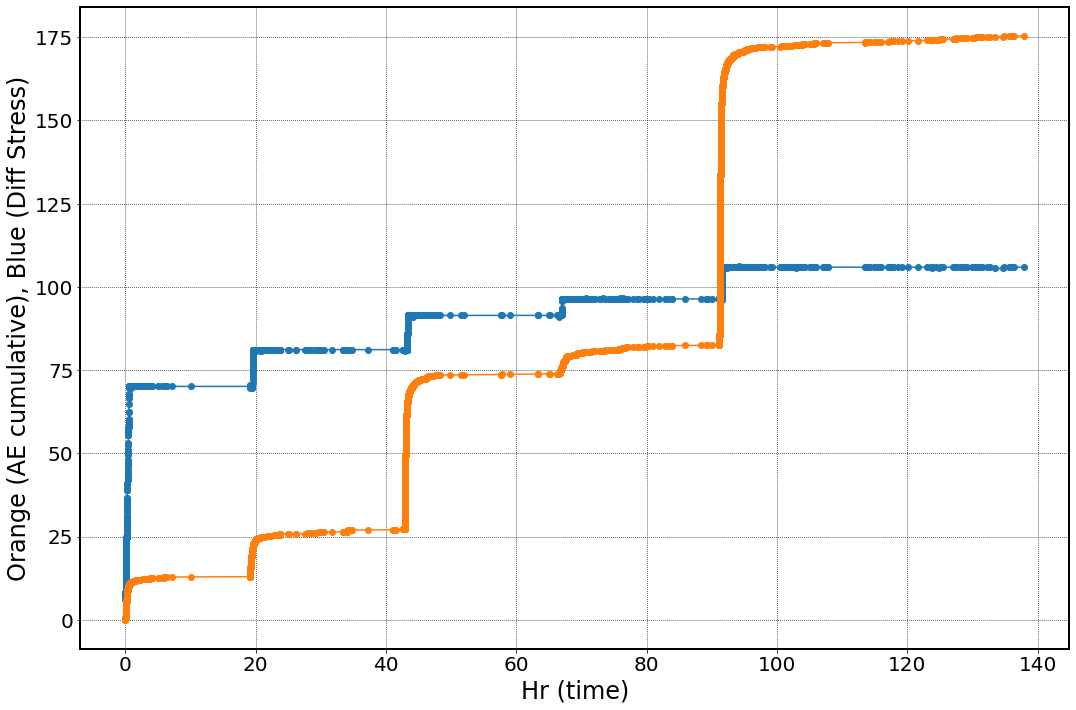

In [40]:
plt.plot(data.time_hr,data.Sig_diff_MPa,'o-')
plt.plot(data.time_hr,np.cumsum(data['count'])/30,'o-')
plt.xlabel('Hr (time)')
plt.ylabel('Orange (AE cumulative), Blue (Diff Stress)')

## Check Synchronization

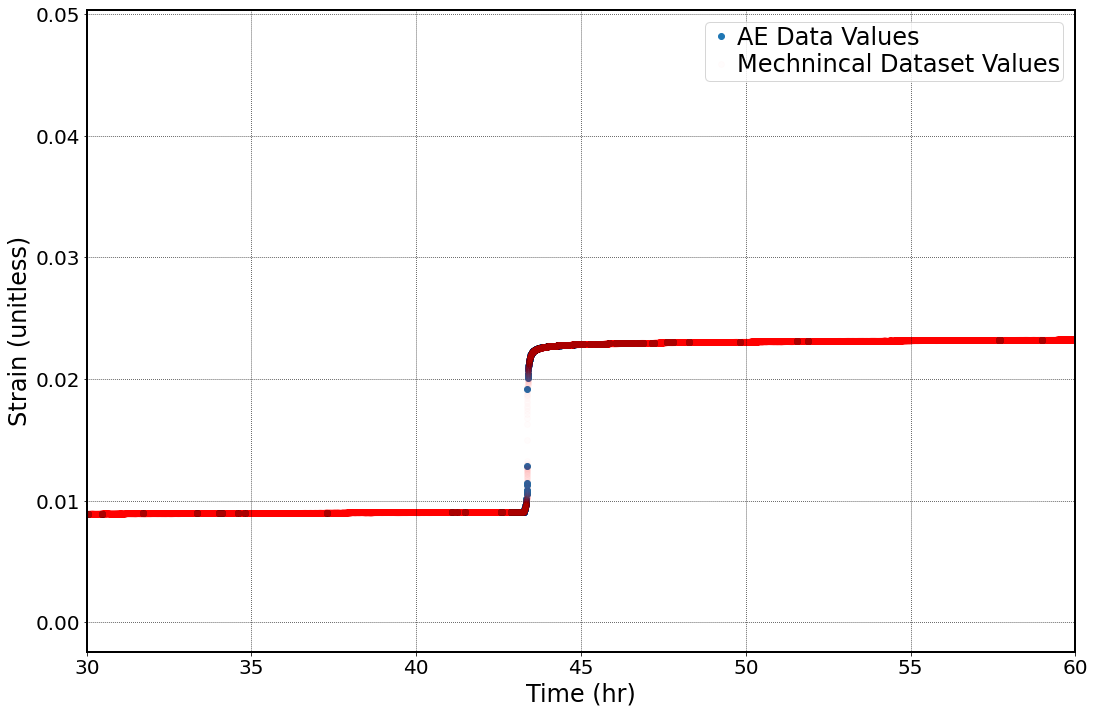

In [41]:
plt.plot(data.time_hr,data.Strain_ax,'o',label='AE Data Values')
plt.plot(data_def.time_hr,data_def.Strain_ax,'ro',alpha=0.01,label='Mechnincal Dataset Values') 
plt.xlim([30,60])
plt.xlabel('Time (hr)')
plt.ylabel('Strain (unitless)')
plt.legend()
#plt.ylim([0.,0.01])

Text(0.5, 0, 'Time (Date)')

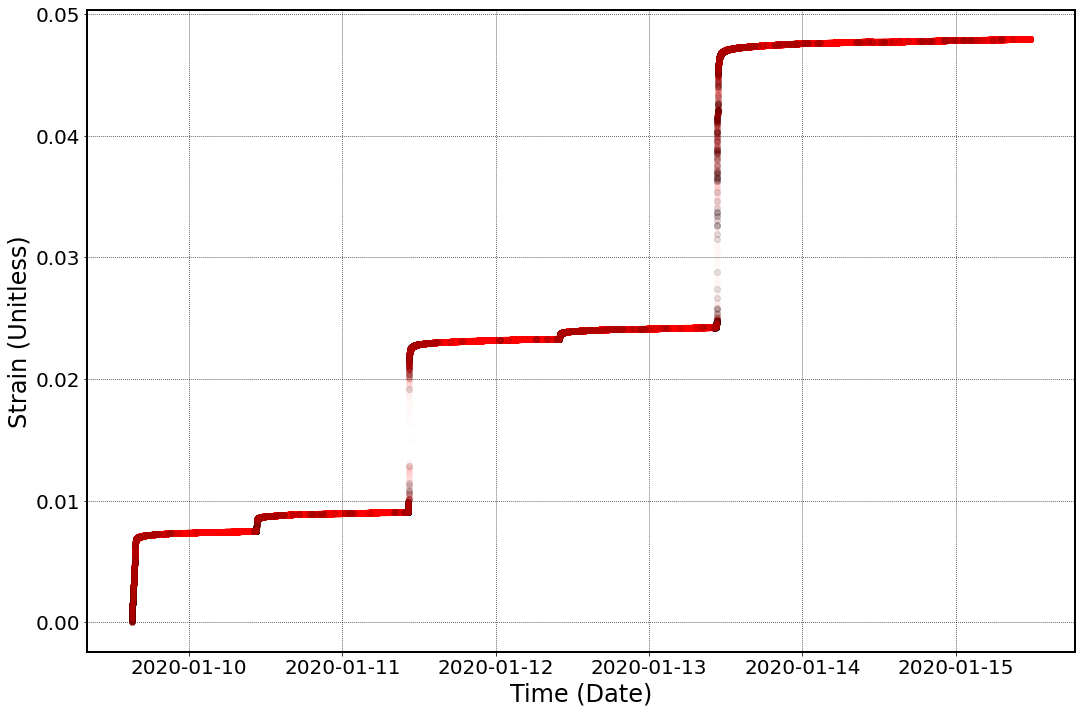

In [42]:
plt.plot(new_data.index,new_data['Strain_ax'],'ko',alpha=.1)
plt.plot(data_def.index,data_def['Strain_ax'],'ro',alpha=0.01)
plt.ylabel('Strain (Unitless)')
plt.xlabel('Time (Date)')
#plt.xlim([np.datetime64('2020-02-19'),np.datetime64('2020-02-20')])
#plt.ylim([0,0.01])
#plt.tight_layout()

### Final Cleaned, Aligned Datasets 

In [43]:
### AE dataset & deformation data with time as the index
# new_data -- AE Data
# new_data_def -- Deformation Data (resampled)

#### Time region cutoff to ensure that both the datasets are comparable

In [46]:
start_date = np.max([new_data_def.index.values[0],new_data.index.values[0]])
end_date = np.min([new_data_def.index.values[-1],new_data.index.values[-1]])
print(f'{start_date}, {end_date}')

2020-01-09T15:00:04.000000000, 2020-01-15T08:55:00.000000000


## Analysis Parts :

a) Make a catalog for the AE data with strain rate etc (extended mechanical catalog)

b) Data plotting with different time aggregations & saving time series for analysis

### Make a time aggregated dataset (mechanical data) to merge with the event catalog

In [47]:
time_window = 60  ## Aggregation Time Window in seconds

In [48]:
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
new_AE_data = pd.merge_asof(new_data, new_data_def_Sampl, left_index = True, right_index = True,
                            direction='forward',tolerance=pd.Timedelta(seconds=time_window),
             suffixes =['','_1min'])
## Note that when we aggregate, the time label is assigned to the end of the time window (right). So, for an event,
#  the relevant data is in the next timestamp (or not relevant - so we have a tolerance) ..

In [49]:
new_AE_data.columns

Index(['index', 'timestamp', 'evID', 'Disp_mm', 'Sig_diff_MPa', 'Strain_ax',
       'Temp', 'time_hr', 'count', 'Disp_mm_1min', 'Sig_diff_MPa_1min',
       'Strain_ax_1min', 'Temp_1min', 't_def', 'time_hr_1min', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')

In [50]:
new_AE_data

index            timestamp                        evID  \
date                                                                          
2020-01-09 15:00:04    209  1578582004000000000   2020.009.630004.226804120   
2020-01-09 15:00:04    210  1578582004000000000   2020.009.630004.226804888   
2020-01-09 15:00:14    211  1578582014000000000   2020.009.630014.226814455   
2020-01-09 15:00:19    212  1578582019000000000   2020.009.630019.226819059   
2020-01-09 15:00:23    213  1578582023000000000   2020.009.630023.226823115   
...                    ...                  ...                         ...   
2020-01-15 06:38:26   5466  1579070306000000000  2020.015.1983826.715106760   
2020-01-15 07:06:36   5467  1579071996000000000  2020.015.1990636.716796490   
2020-01-15 07:06:38   5468  1579071998000000000  2020.015.1990638.716798597   
2020-01-15 07:25:45   5469  1579073145000000000  2020.015.1992545.717945520   
2020-01-15 08:55:00   5470  1579078500000000000  2020.015.2005500.723300795   

                     Disp_mm  Sig_diff_MPa  Strain_ax     Temp     time_hr  \
date                                                                         
2020-01-09 15:00:04  1.49281        6.0958   0.000000  78.1701    0.000000   
2020-01-09 15:00:04  1.49281        6.0958   0.000000  78.1701    0.000000   
2020-01-09 15:00:14  1.49564        6.0958   0.000037  78.1337    0.002778   
2020-01-09 15:00:19  1.49847        6.4767   0.000073  78.1337    0.004167   
2020-01-09 15:00:23  1.49989        6.4767   0.000092  78.1337    0.005278   
...                      ...           ...        ...      ...         ...   
2020-01-15 06:38:26  5.18451      105.9138   0.047932  80.5725  135.639444   
2020-01-15 07:06:36  5.18451      105.9138   0.047932  80.6817  136.108889   
2020-01-15 07:06:38  5.18593      105.9138   0.047950  80.6453  136.109444   
2020-01-15 07:25:45  5.18451      105.9138   0.047932  80.7181  136.428056   
2020-01-15 08:55:00  5.18451      105.9138   0.047932  80.7181  137.915556   

                     count  Disp_mm_1min  ...  AE_rate_count   strain_rate  \
date                                      ...                                
2020-01-09 15:00:04    1.0      1.500942  ...           13.0  0.000000e+00   
2020-01-09 15:00:04    1.0      1.500942  ...           13.0  0.000000e+00   
2020-01-09 15:00:14    1.0      1.500942  ...           13.0  0.000000e+00   
2020-01-09 15:00:19    1.0      1.500942  ...           13.0  0.000000e+00   
2020-01-09 15:00:23    1.0      1.500942  ...           13.0  0.000000e+00   
...                    ...           ...  ...            ...           ...   
2020-01-15 06:38:26    1.0      5.184040  ...            1.0 -1.222626e-06   
2020-01-15 07:06:36    1.0      5.184322  ...            2.0  6.123950e-07   
2020-01-15 07:06:38    1.0      5.184322  ...            2.0  6.123950e-07   
2020-01-15 07:25:45    1.0      5.184628  ...            1.0  1.226954e-06   
2020-01-15 08:55:00    1.0      5.184534  ...            0.0 -6.145590e-07   

                     stress_rate  AE_rate_count_rate  Sig_AE_rate  \
date                                                                
2020-01-09 15:00:04      0.00000                 0.0     0.000000   
2020-01-09 15:00:04      0.00000                 0.0     0.000000   
2020-01-09 15:00:14      0.00000                 0.0     0.000000   
2020-01-09 15:00:19      0.00000                 0.0     0.000000   
2020-01-09 15:00:23      0.00000                 0.0     0.000000   
...                          ...                 ...          ...   
2020-01-15 06:38:26      0.01905                 1.0     0.004565   
2020-01-15 07:06:36      0.01270                 2.0     0.009129   
2020-01-15 07:06:38      0.01270                 2.0     0.009129   
2020-01-15 07:25:45     -0.01270                 1.0     0.004565   
2020-01-15 08:55:00     -0.00635                 0.0     0.000000   

                     strain_rate_AE_rate  strain_AE_rate  Sig_str

In [51]:
new_AE_data.to_csv(path_AE_data.split('.csv')[0]+'_AppendedMechanical_'+time_agg+'.csv')

In [52]:
del new_AE_data

## Plotting/Analysis of the data with AE rate etc 

In [53]:
try  :
    os.mkdir(path_to_save_out_time_series+name_exp)
except :
    print(f' {path_to_save_out_time_series+name_exp} Exists')
    
try  :
    os.mkdir(path_to_save_out_time_series+name_exp+'/'+time_agg)
except :
    print(f"{path_to_save_out_time_series+name_exp+'/'+time_agg} Exists")

path_save_file = path_to_save_out_time_series+name_exp+'/'+time_agg

 /home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Dry_Basalt Exists
/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Dry_Basalt/1min Exists


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1   36 1175 2603 4021 5496]
Time(hr) for the stress steps:  [2.45833333e-02 1.95911111e+01 4.33912500e+01 6.70245833e+01
 9.16079167e+01]


53330

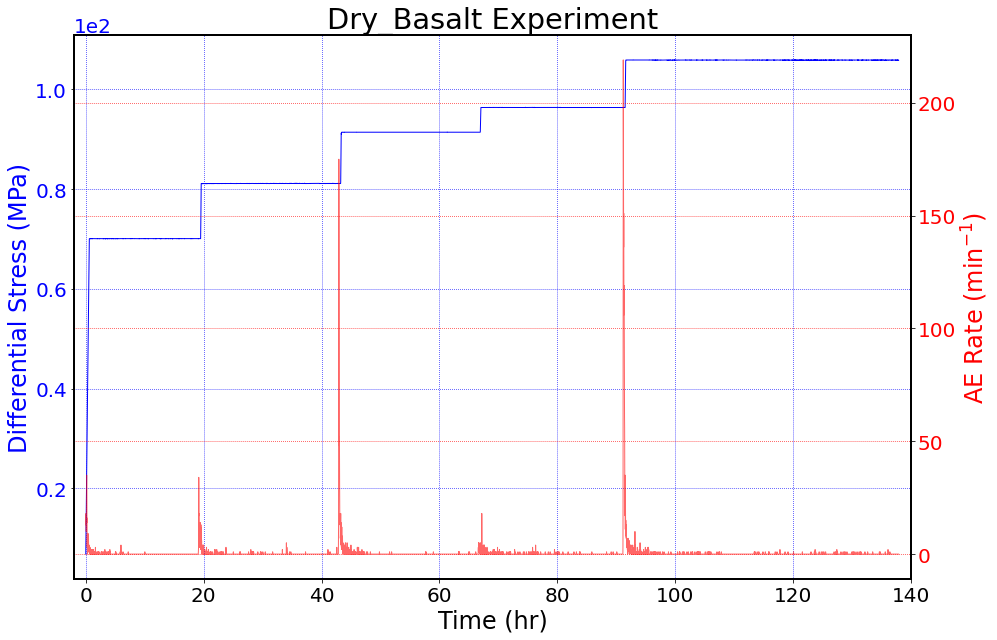

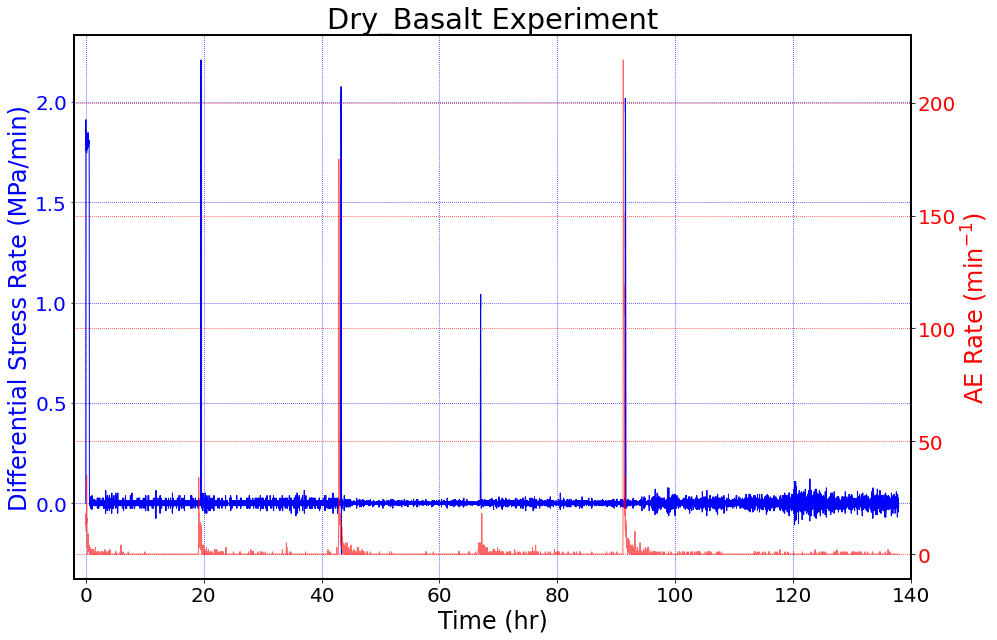

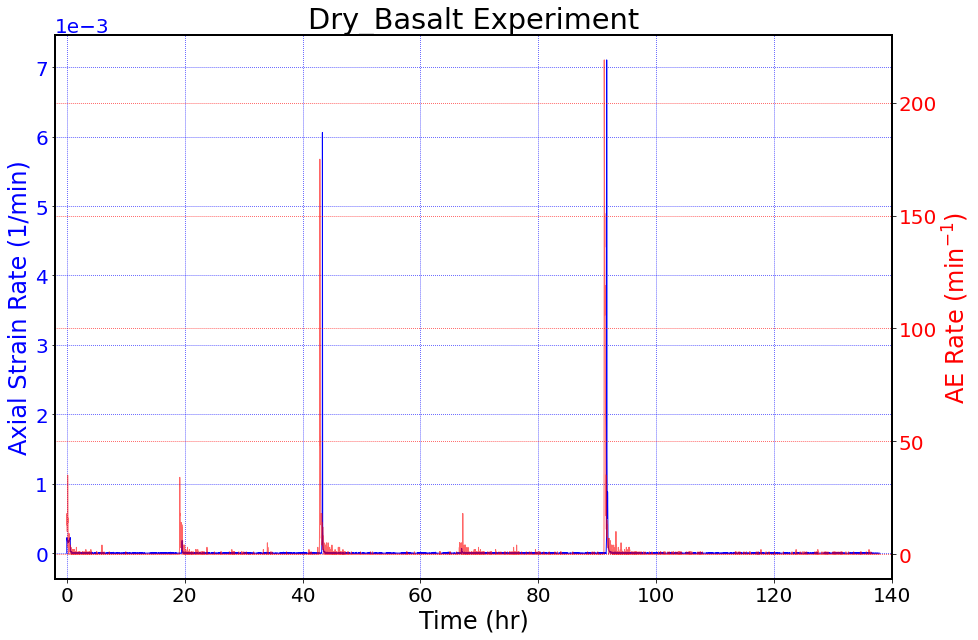

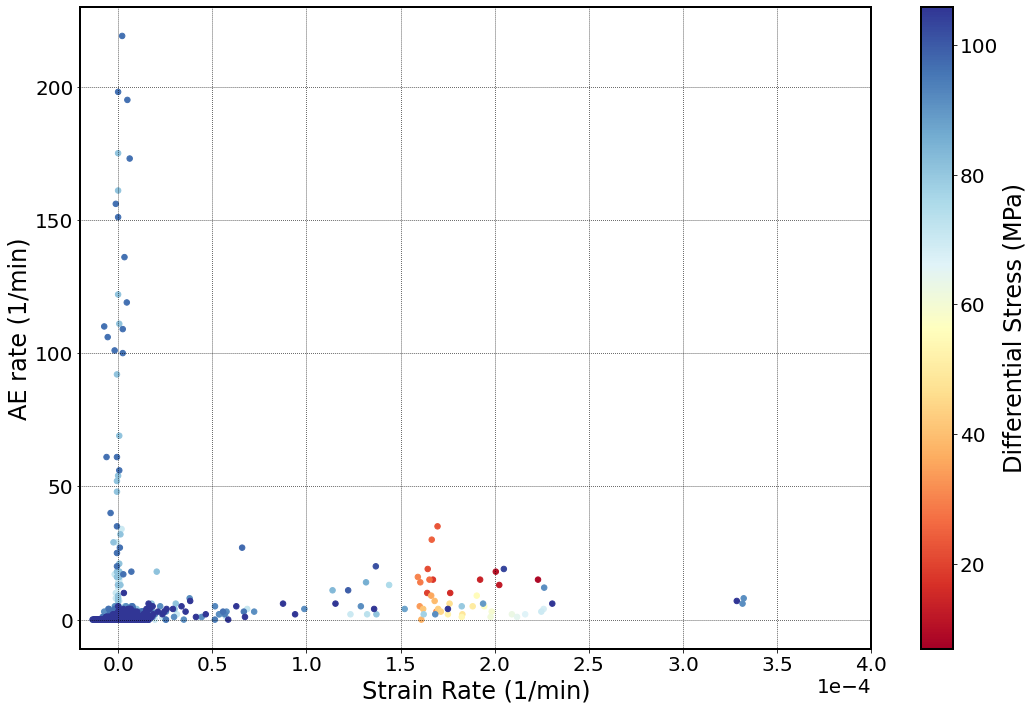

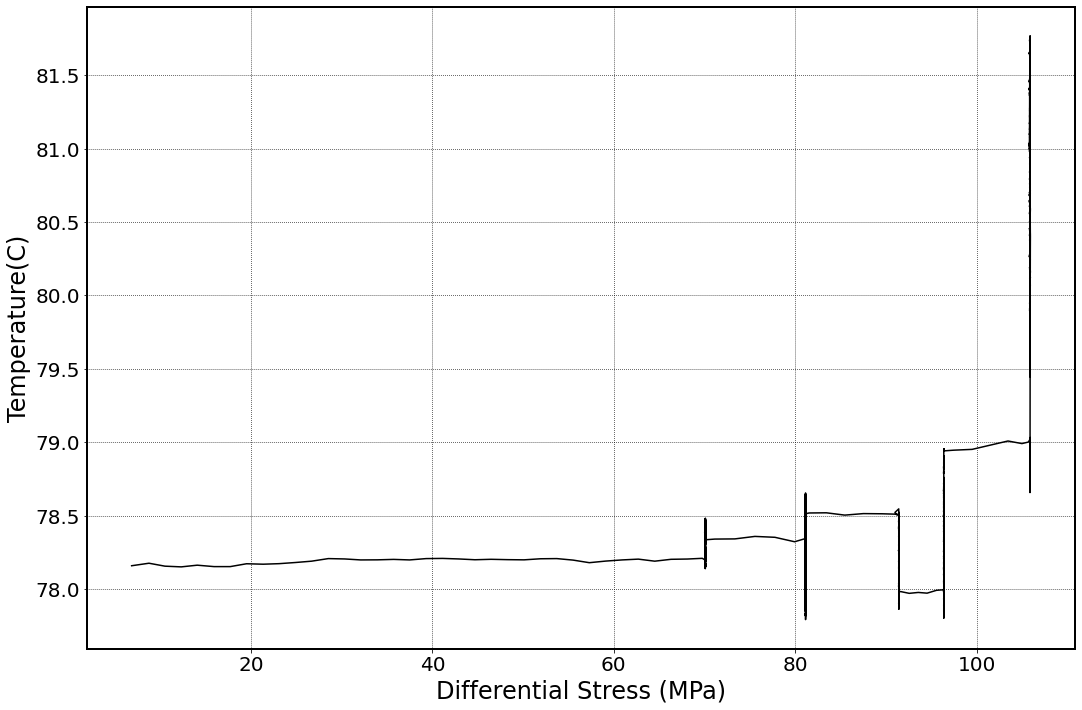

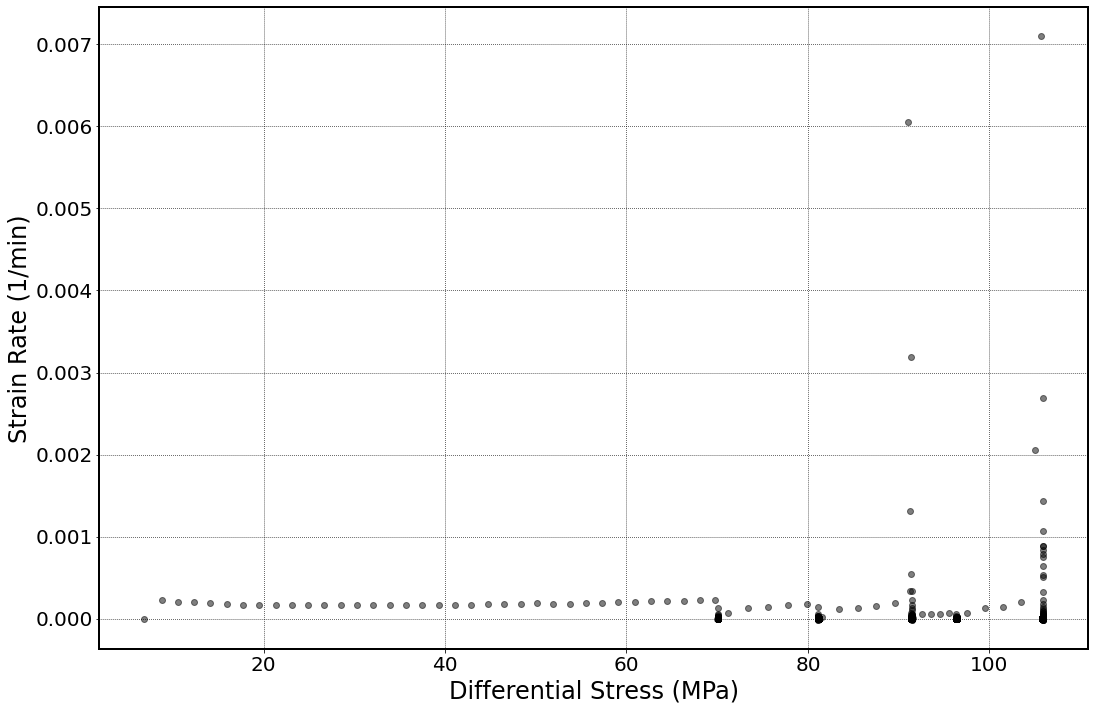

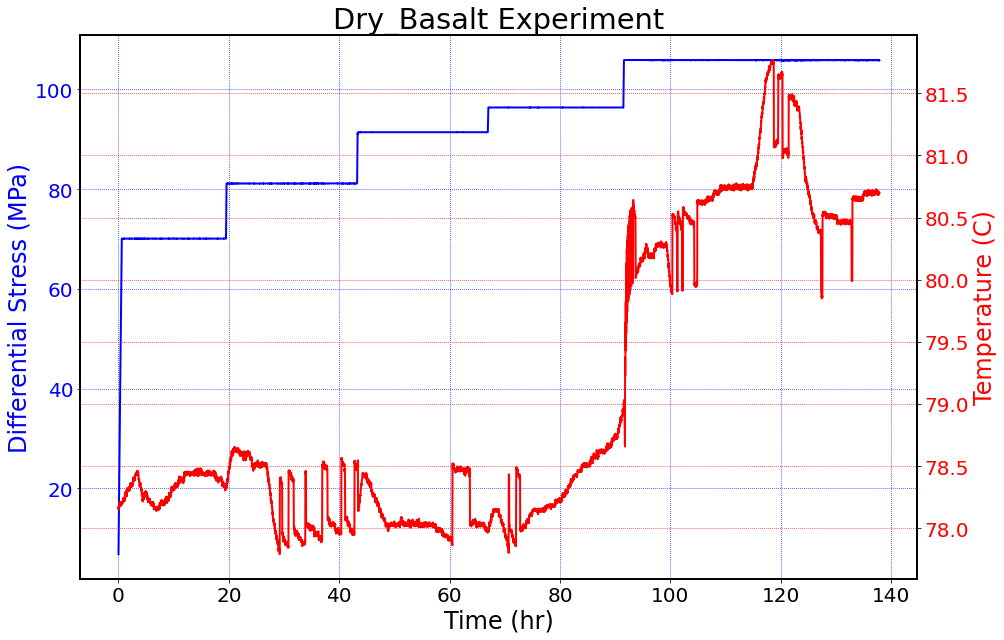

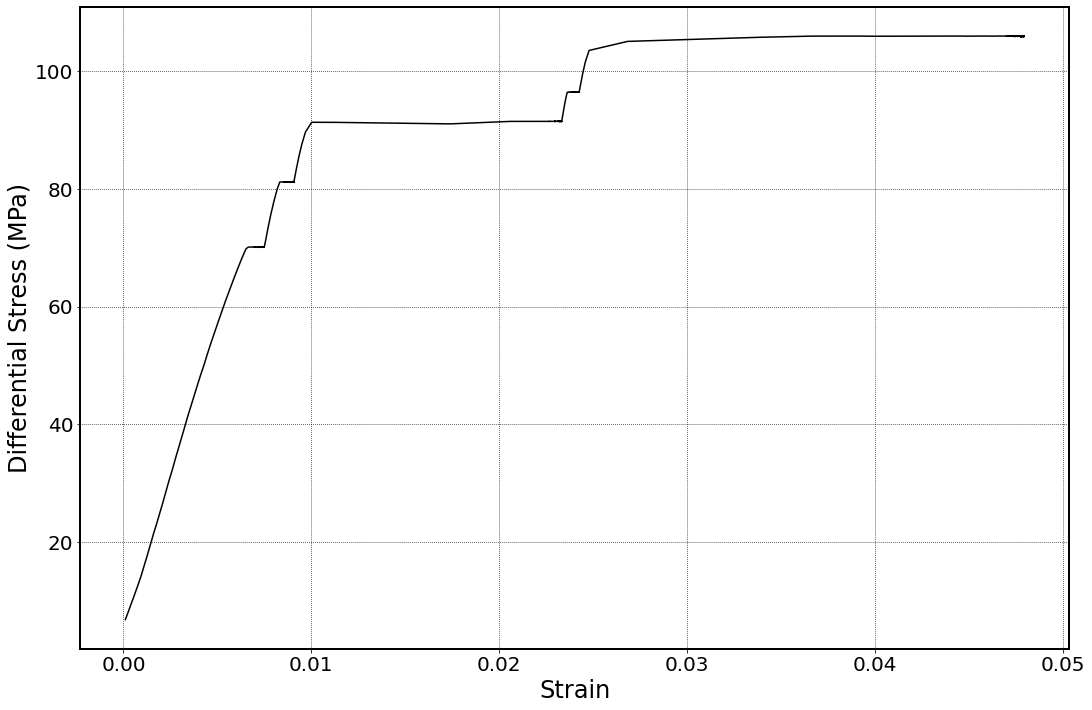

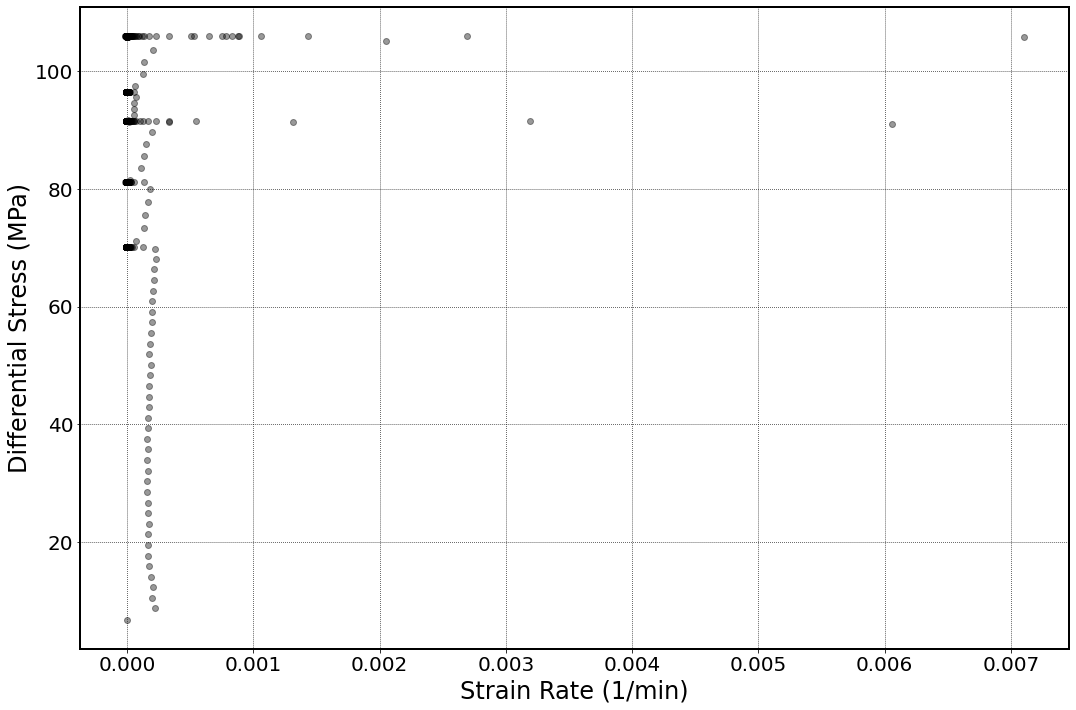

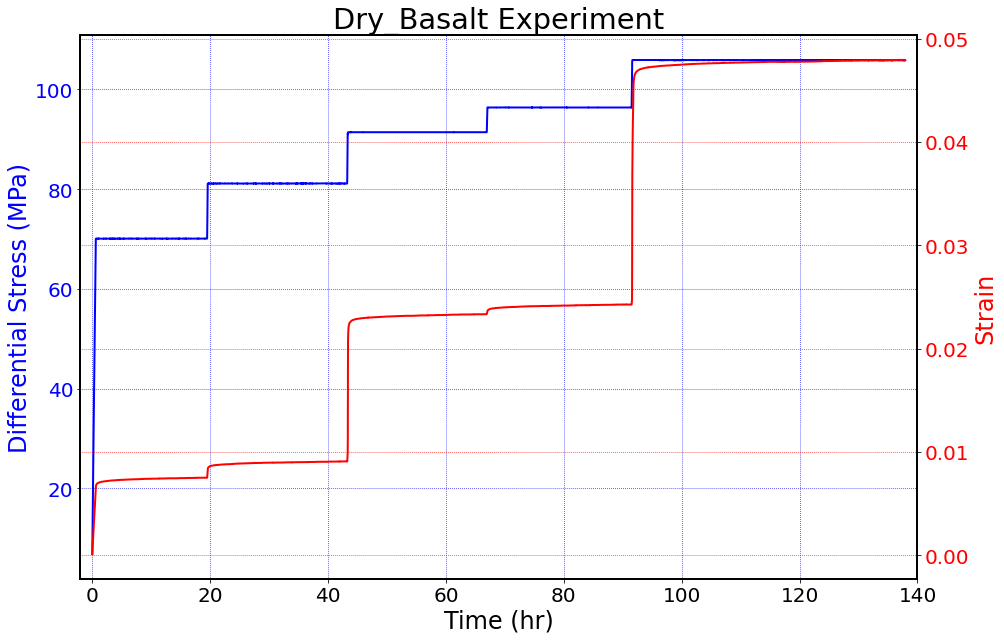

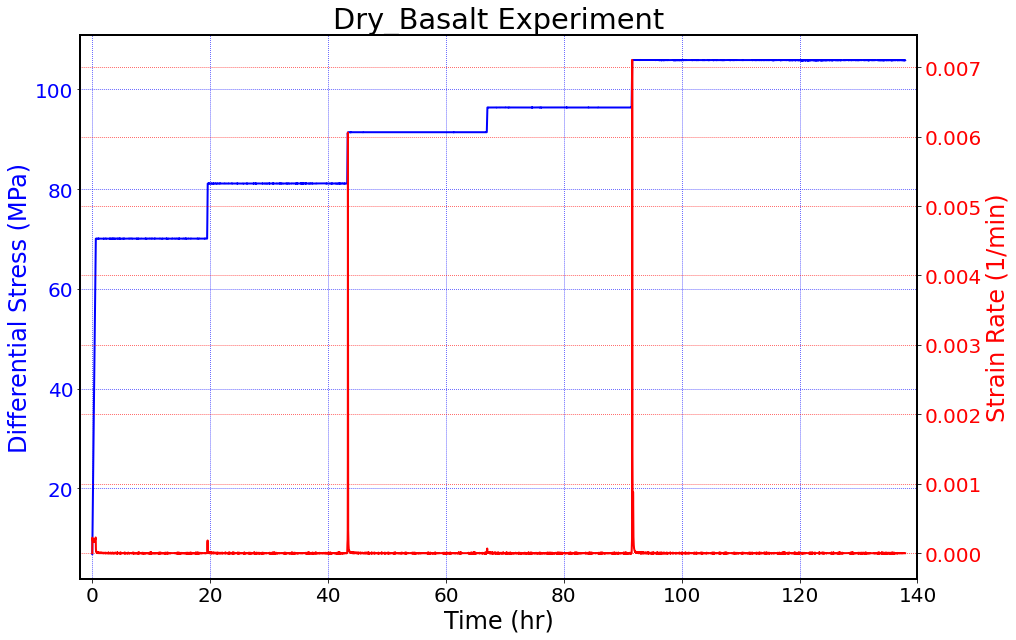

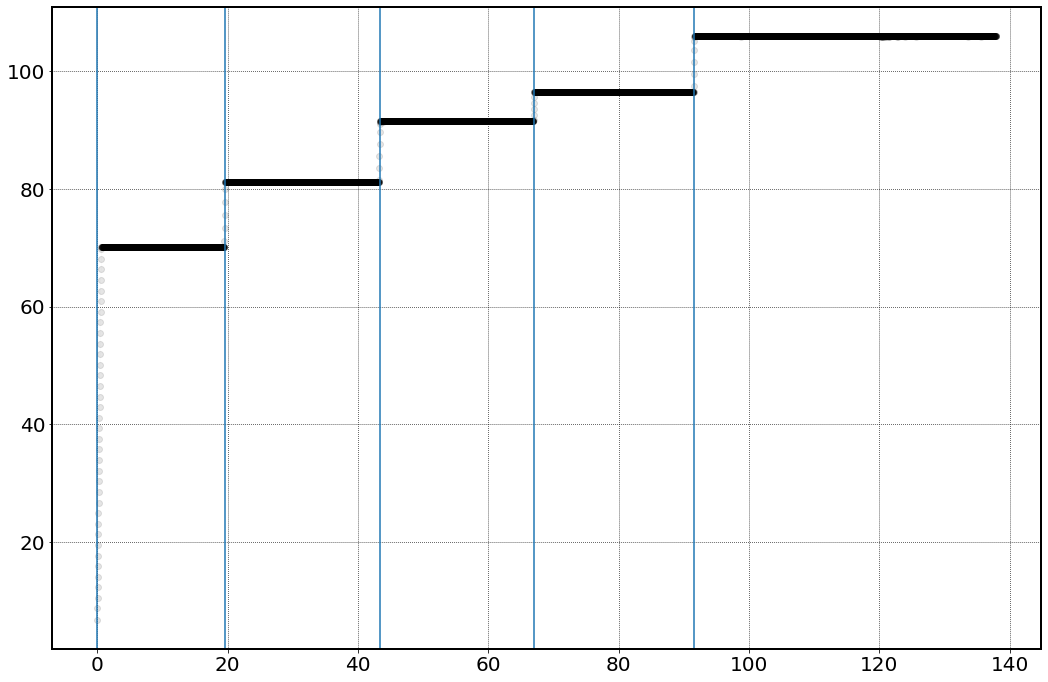

In [55]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1   18  588 1300 2010 2748]
Time(hr) for the stress steps:  [4.95833333e-02 1.96161111e+01 4.33495833e+01 6.70162500e+01
 9.16162500e+01]


54063

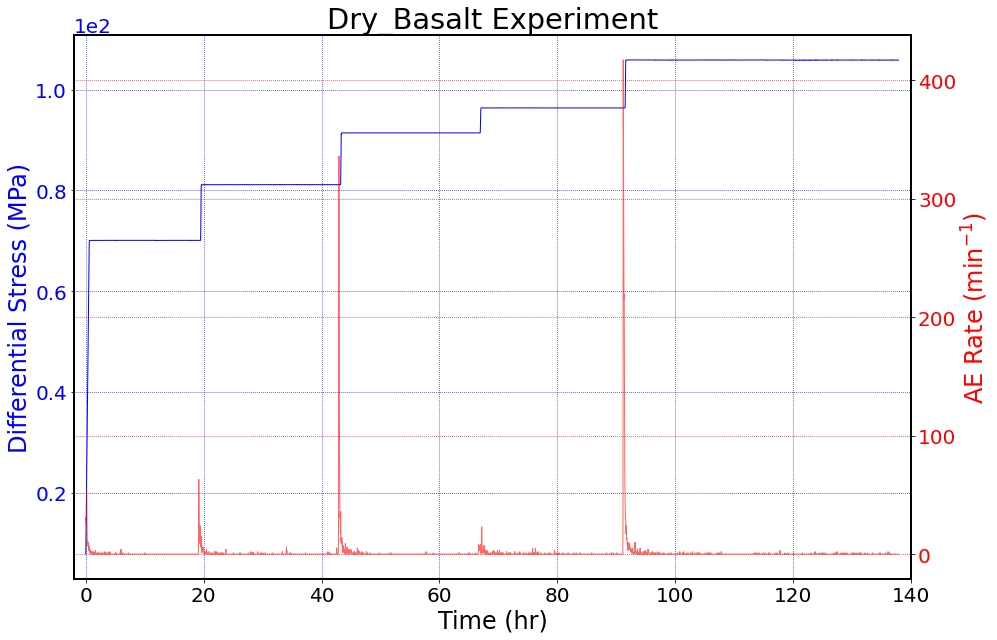

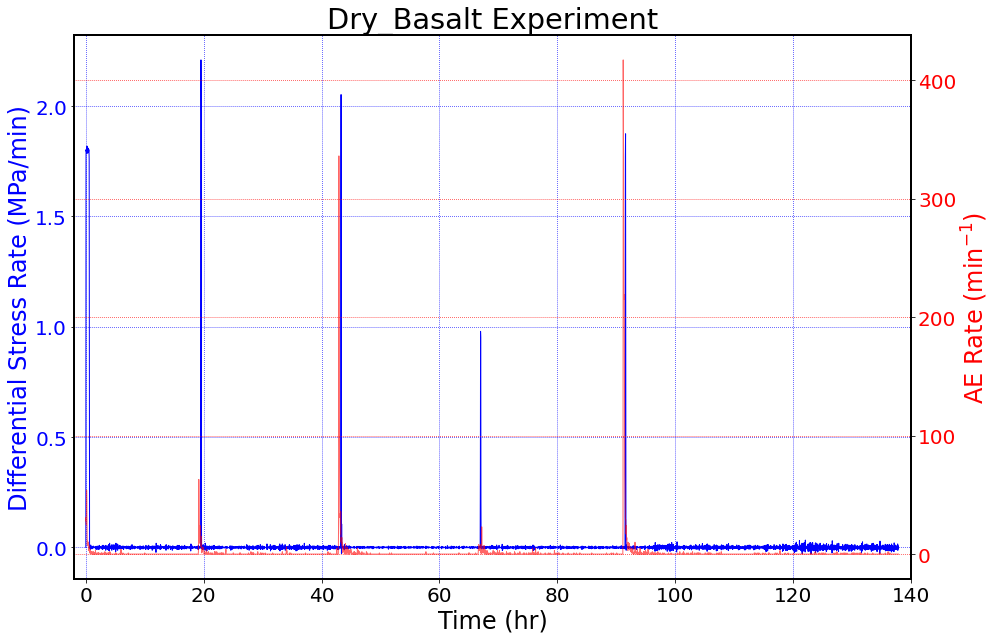

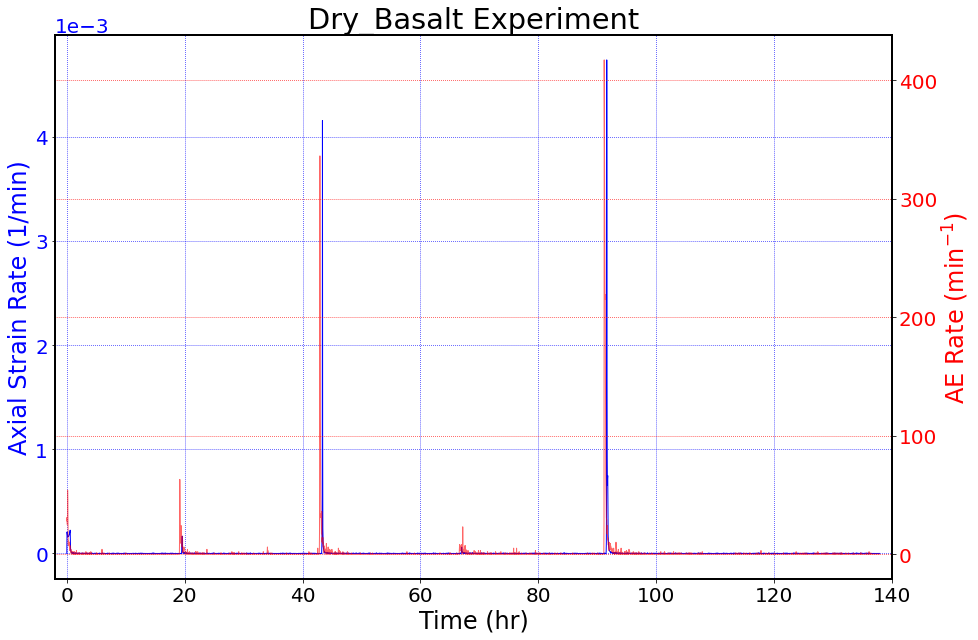

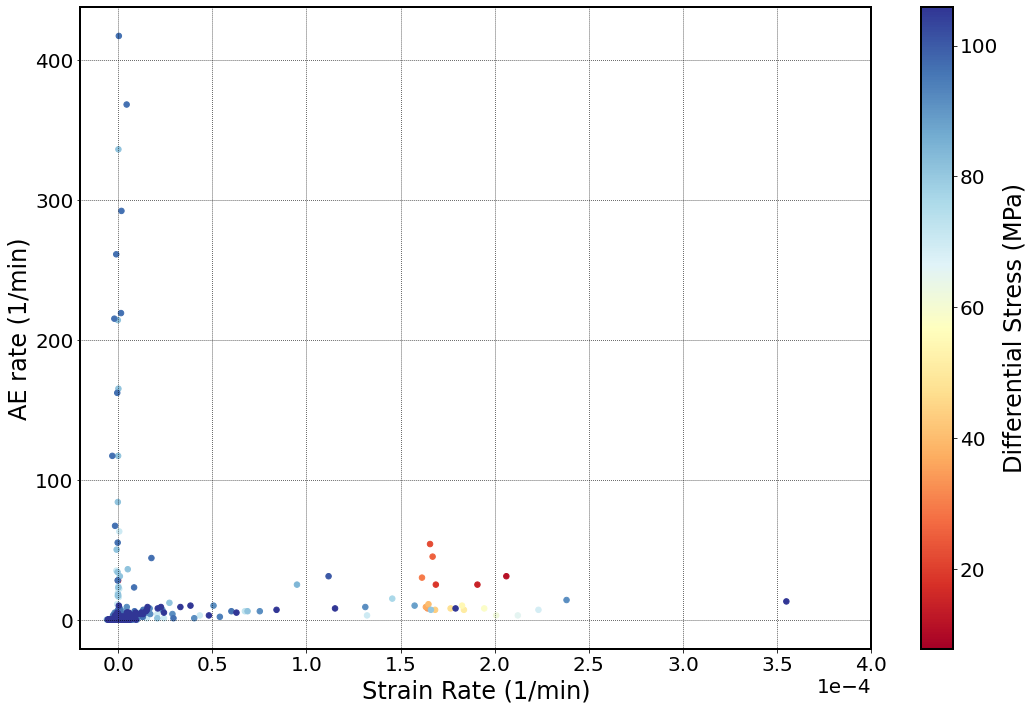

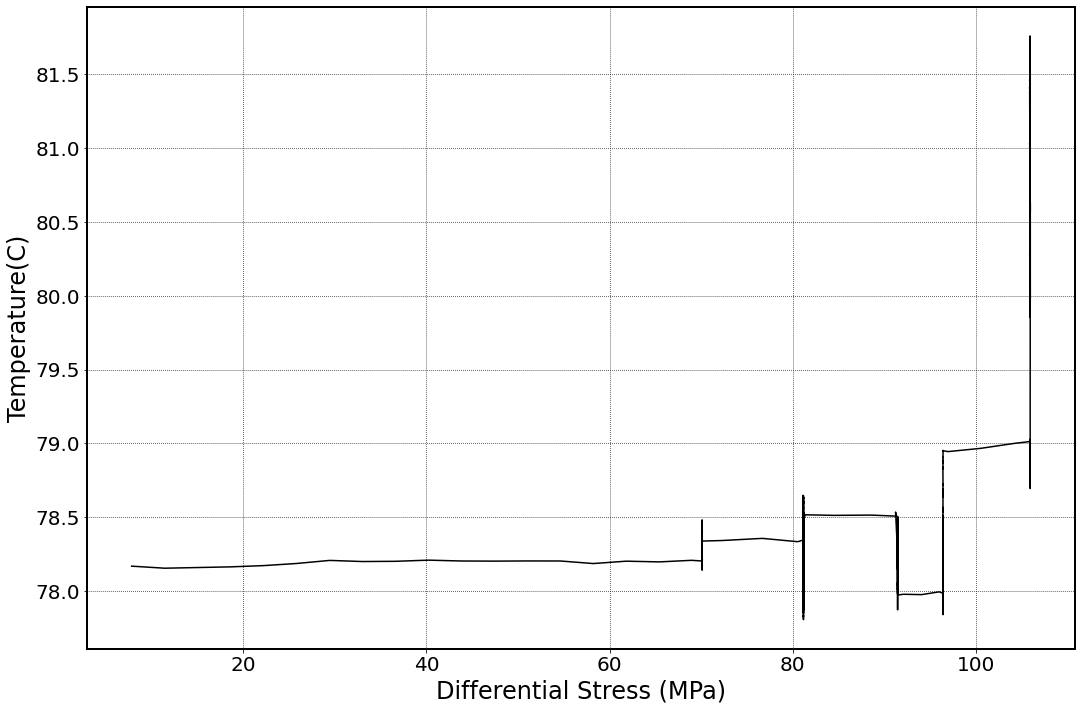

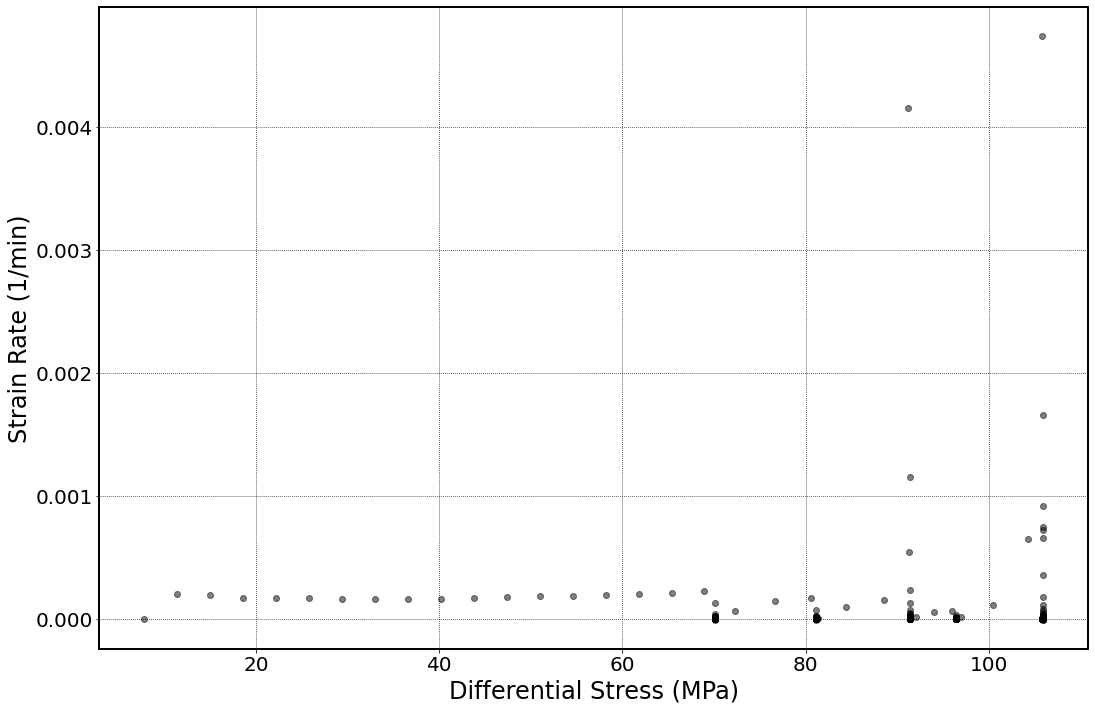

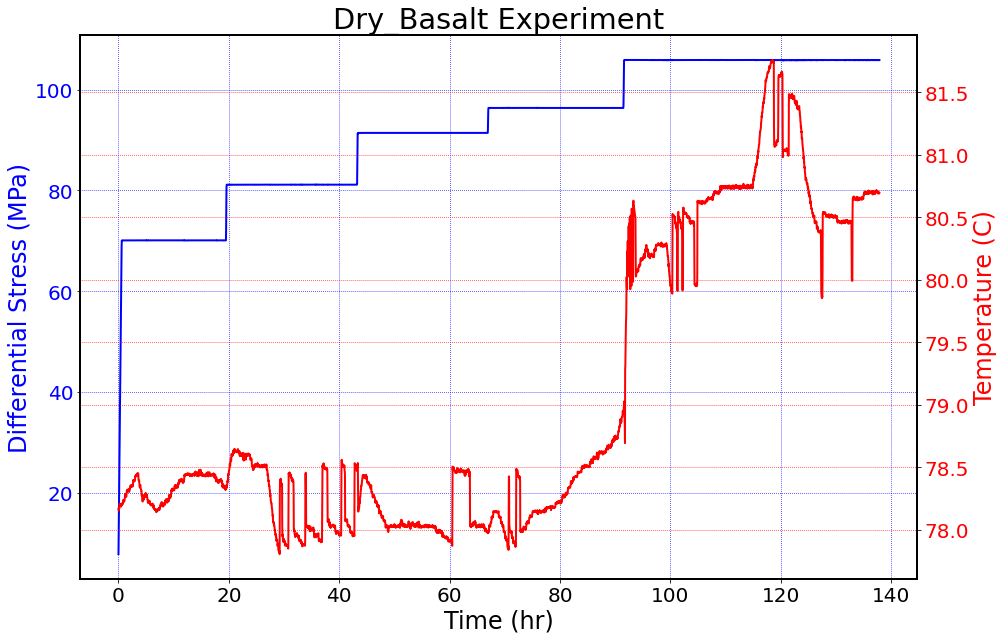

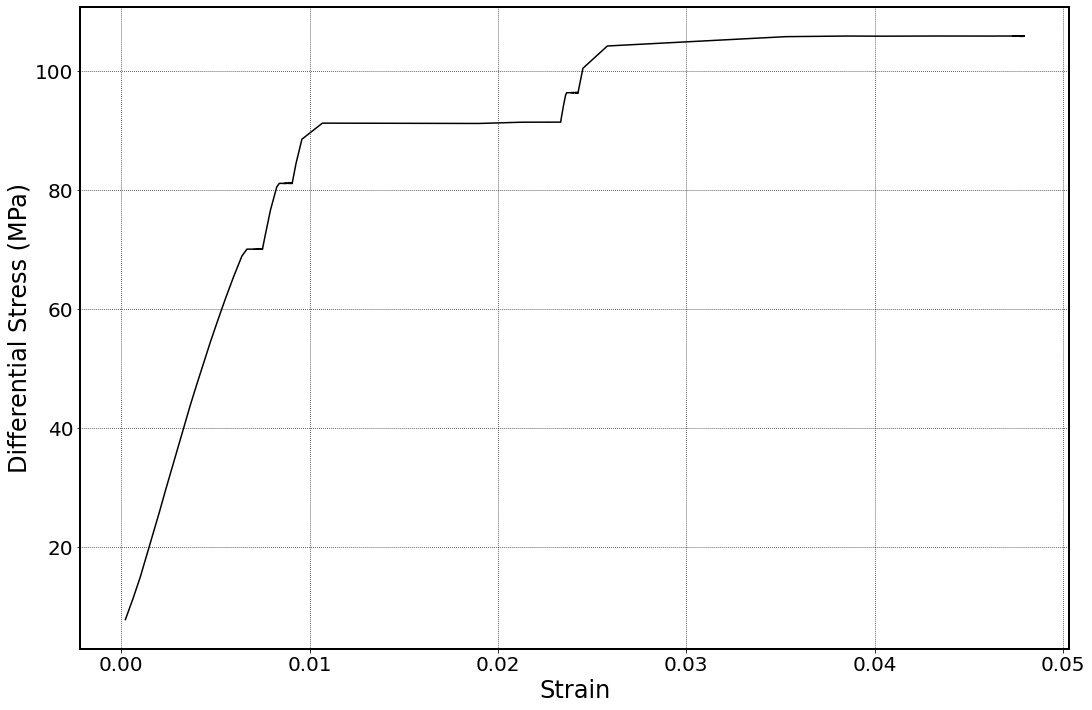

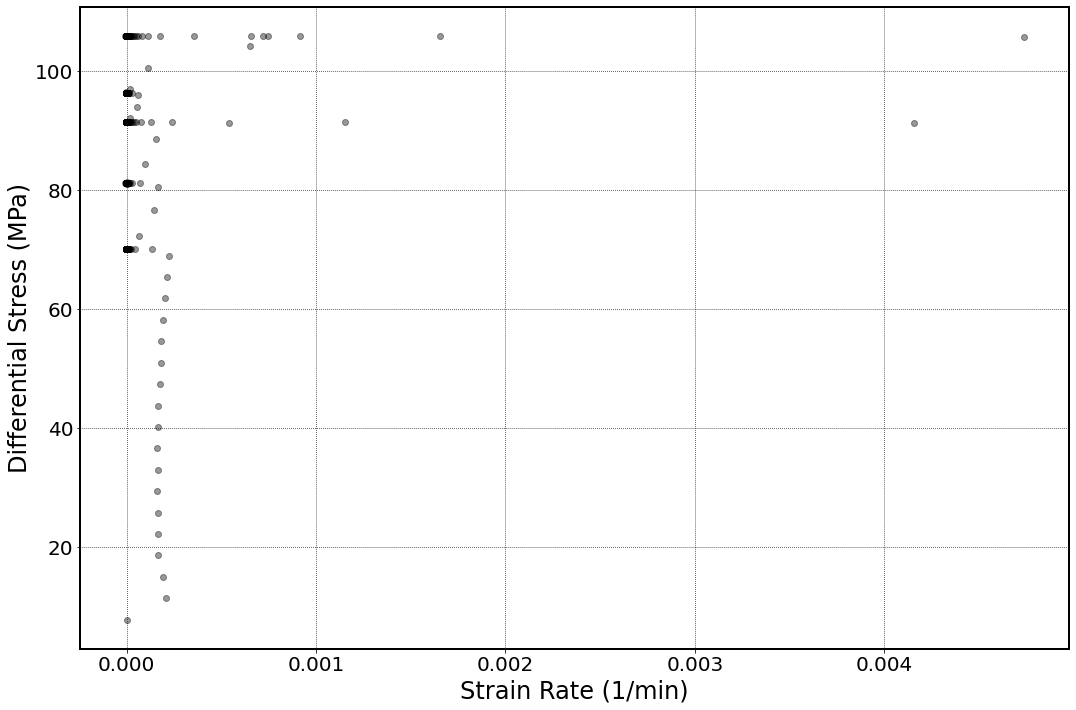

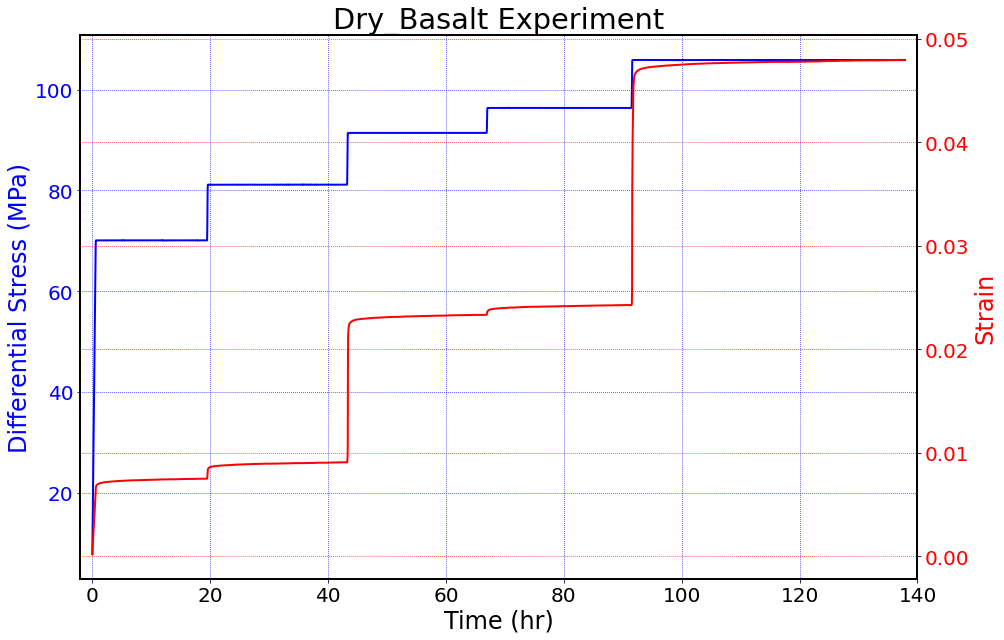

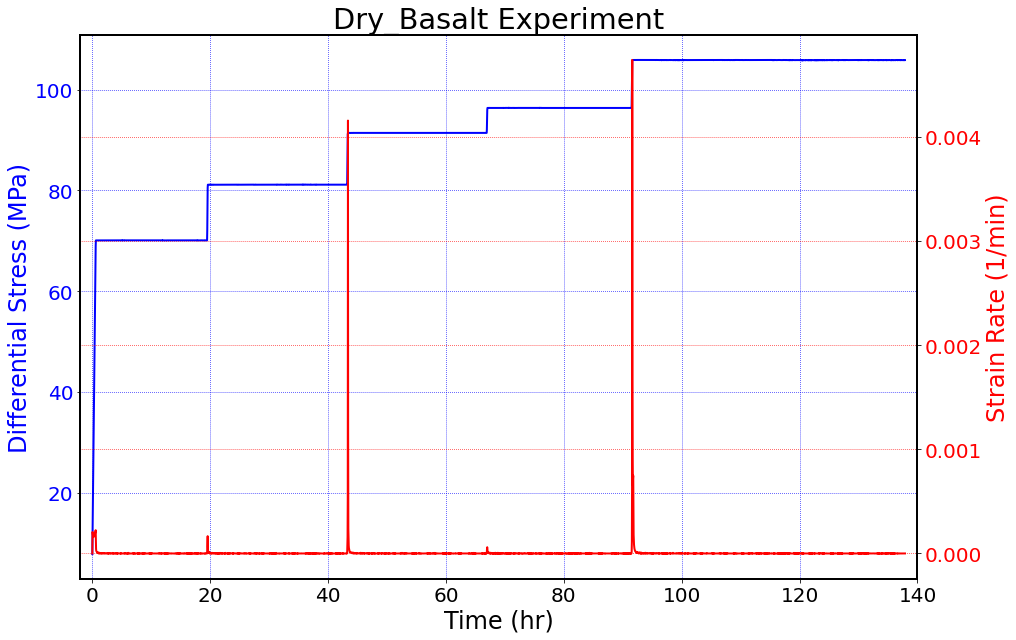

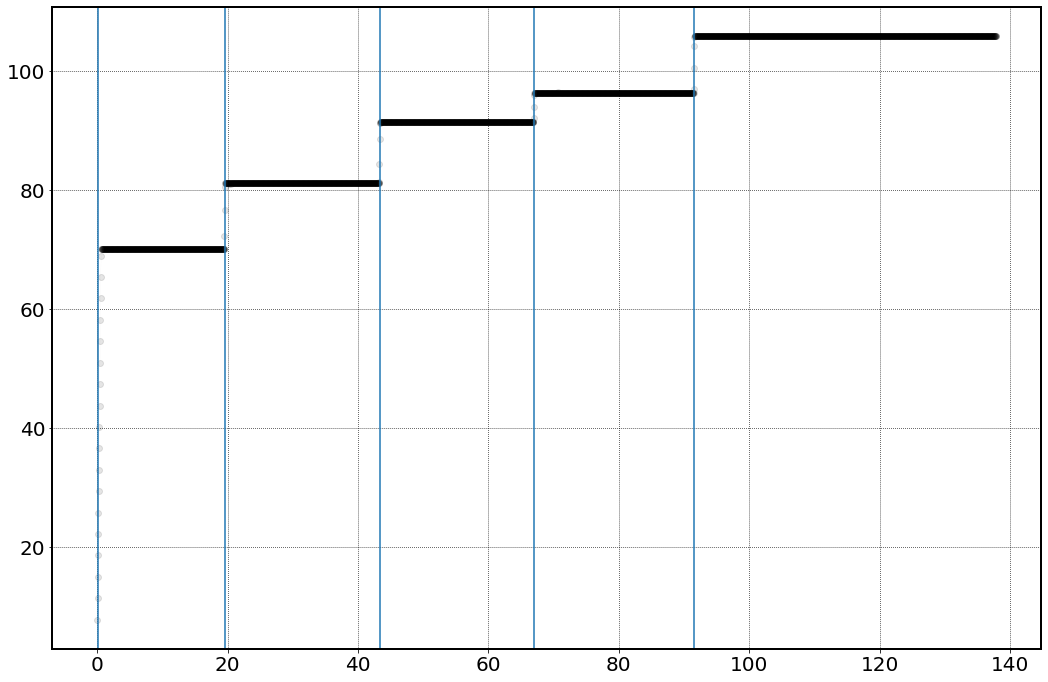

In [56]:
time_window = 120
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1   12  392  867 1340 1832]
Time(hr) for the stress steps:  [7.45833333e-02 1.96244444e+01 4.33745833e+01 6.70245833e+01
 9.16245833e+01]


52359

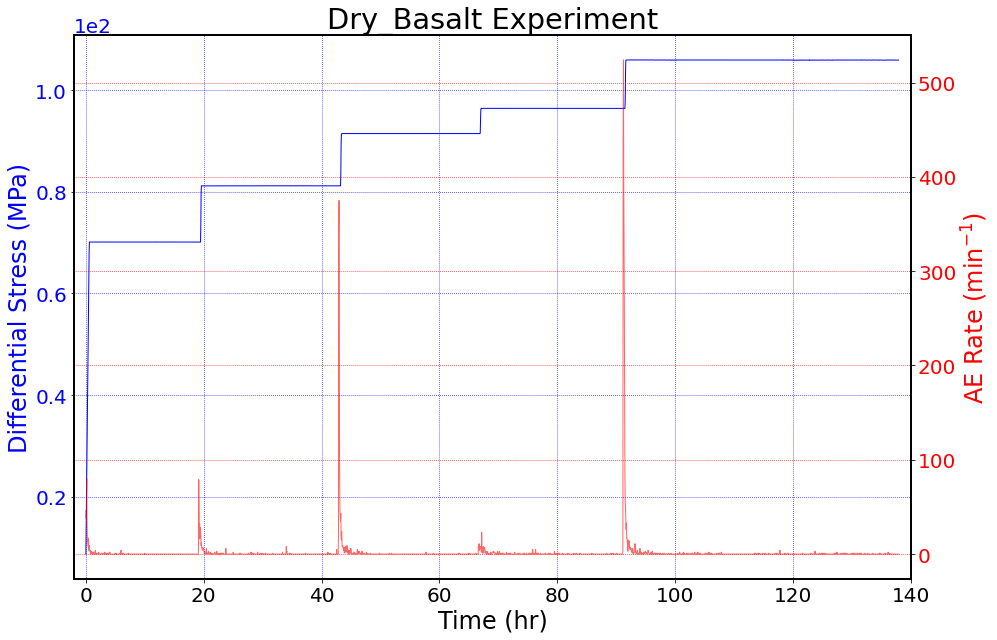

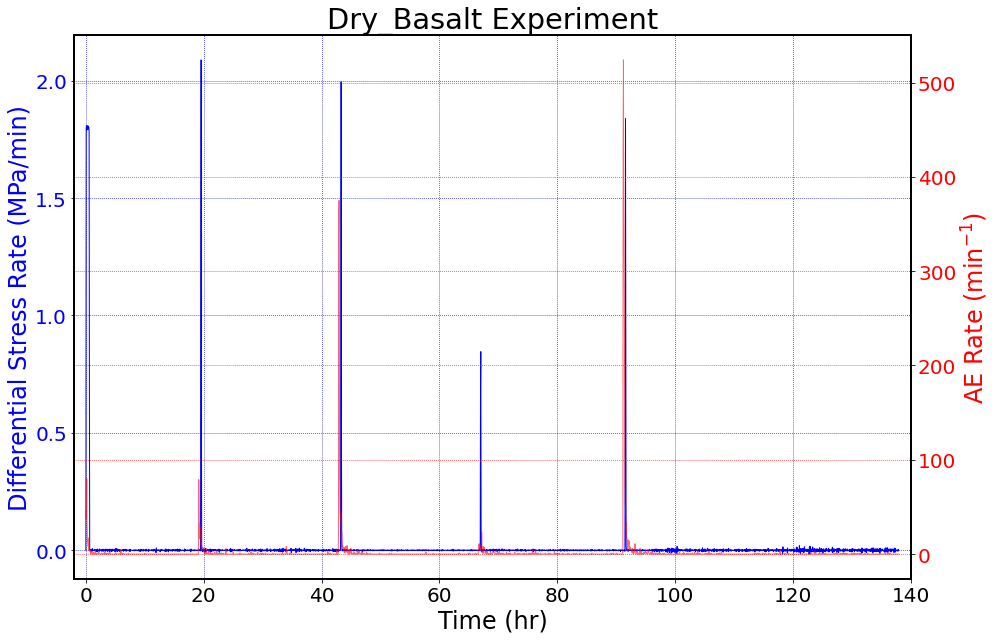

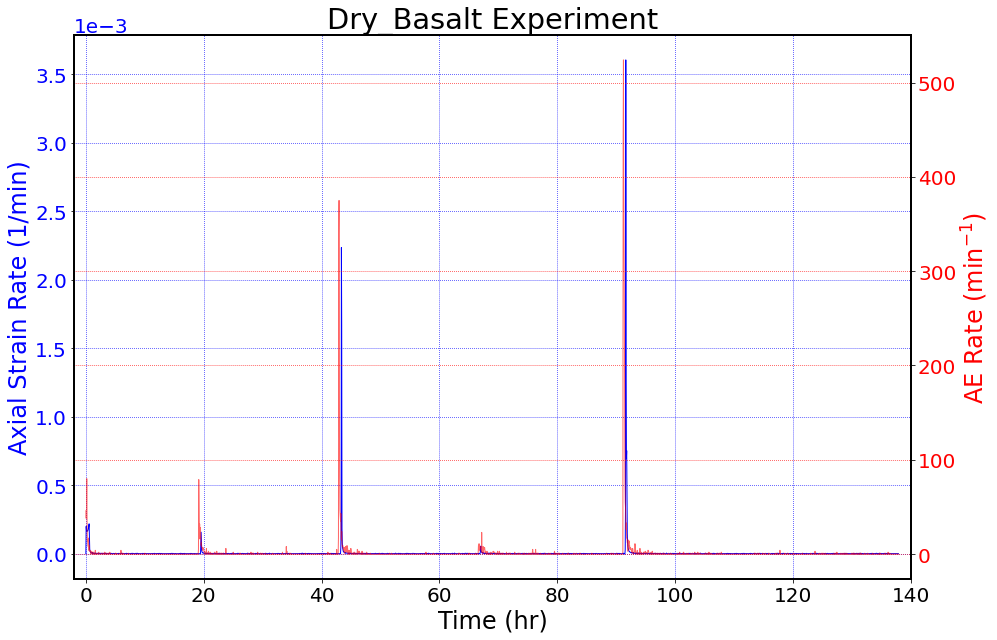

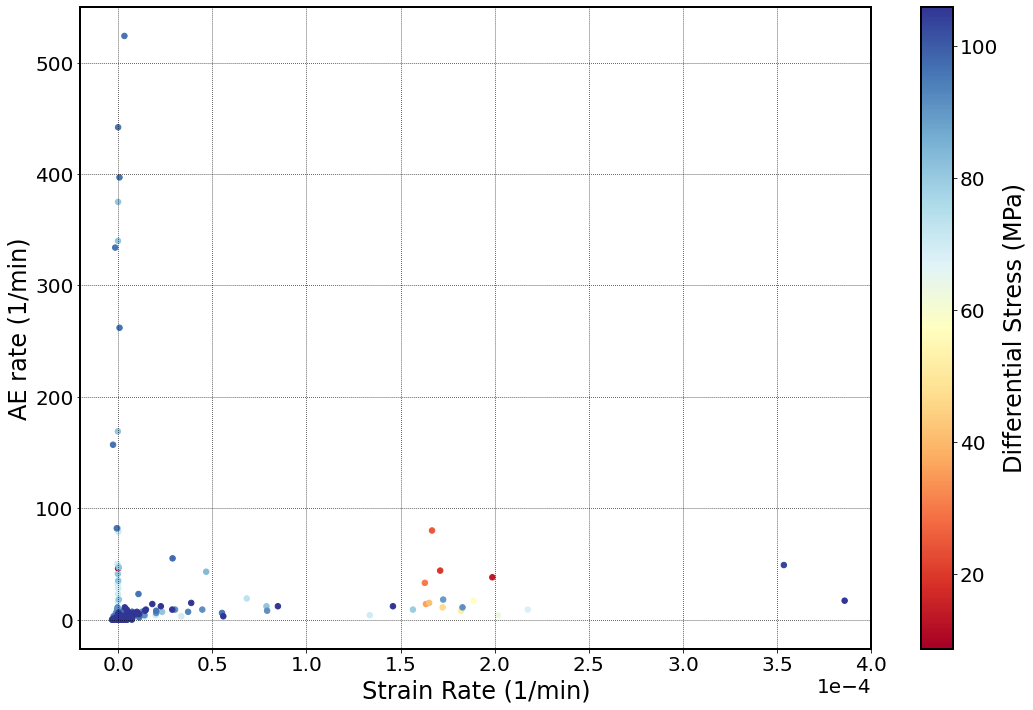

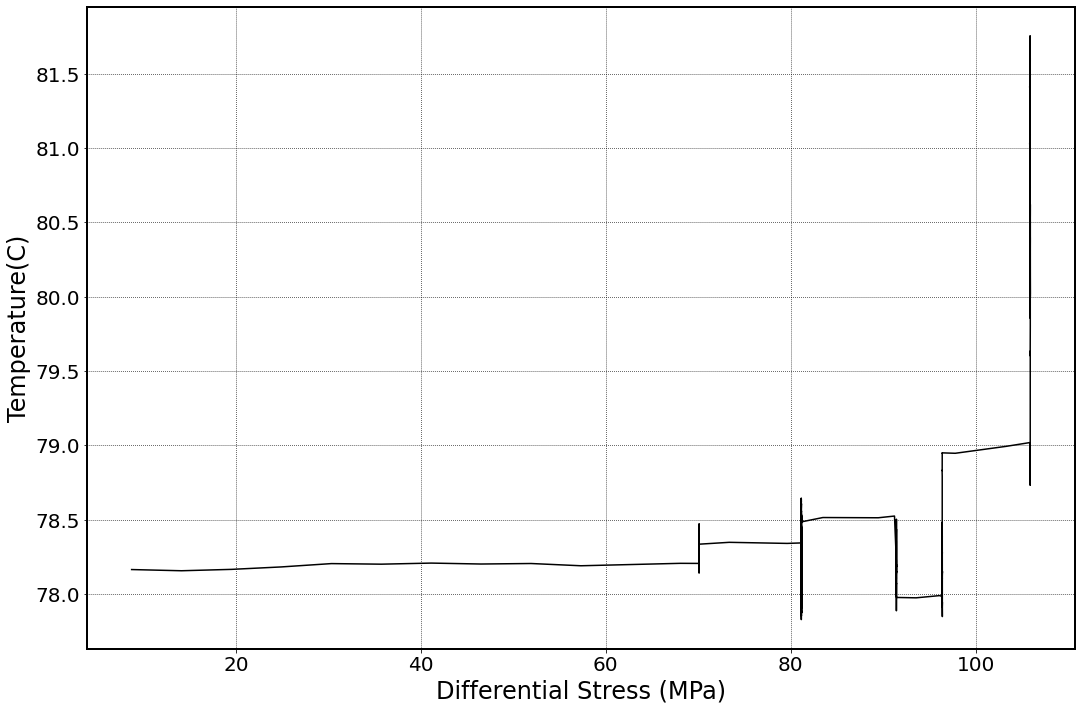

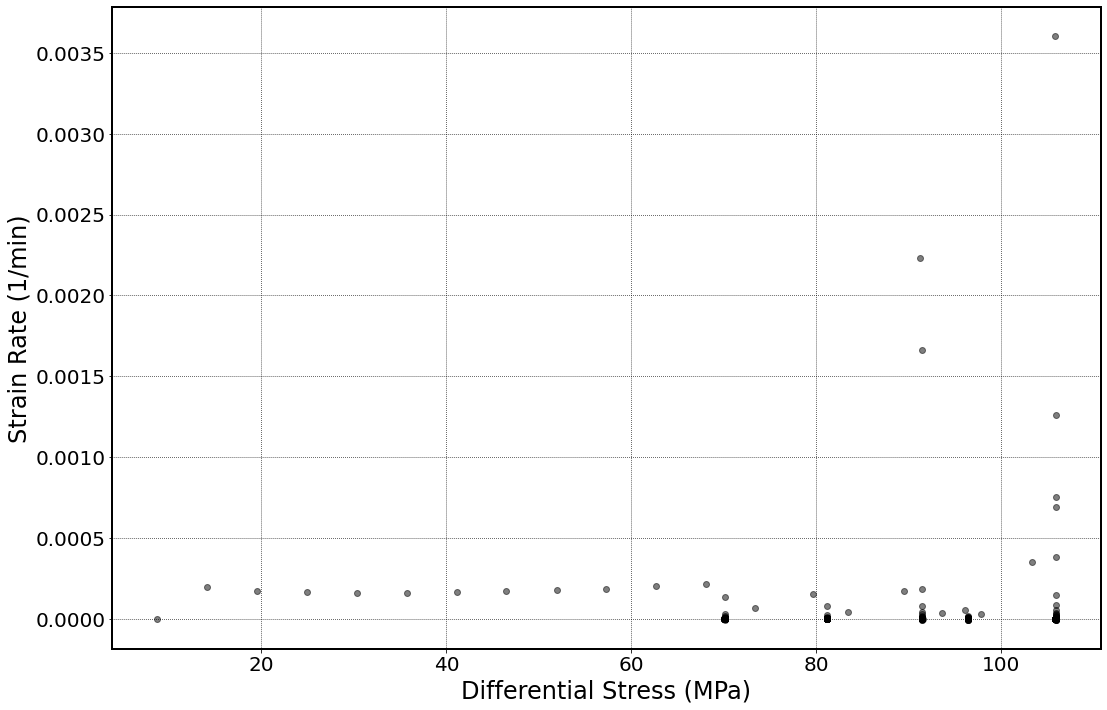

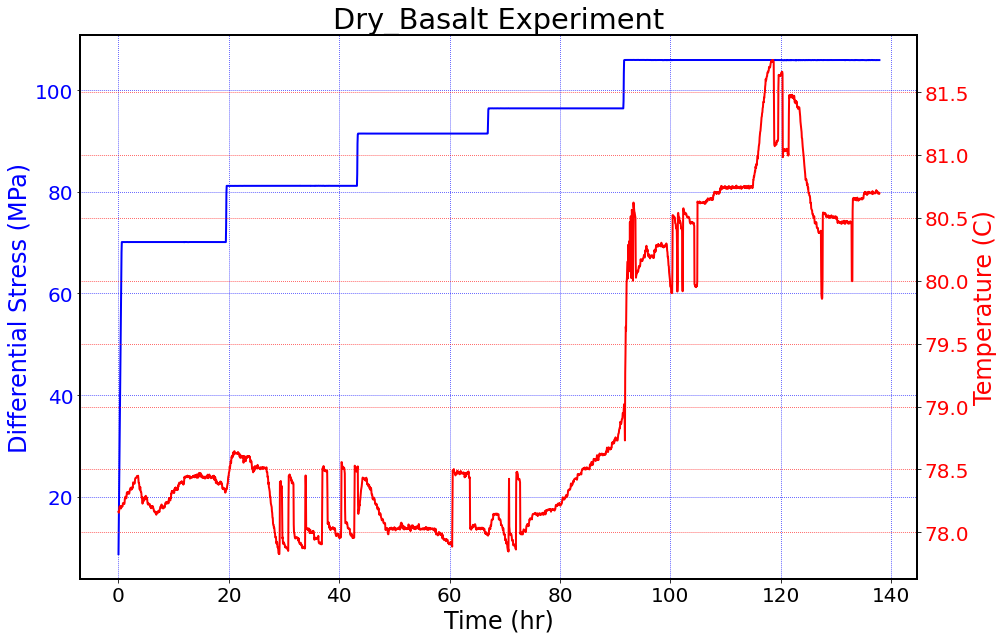

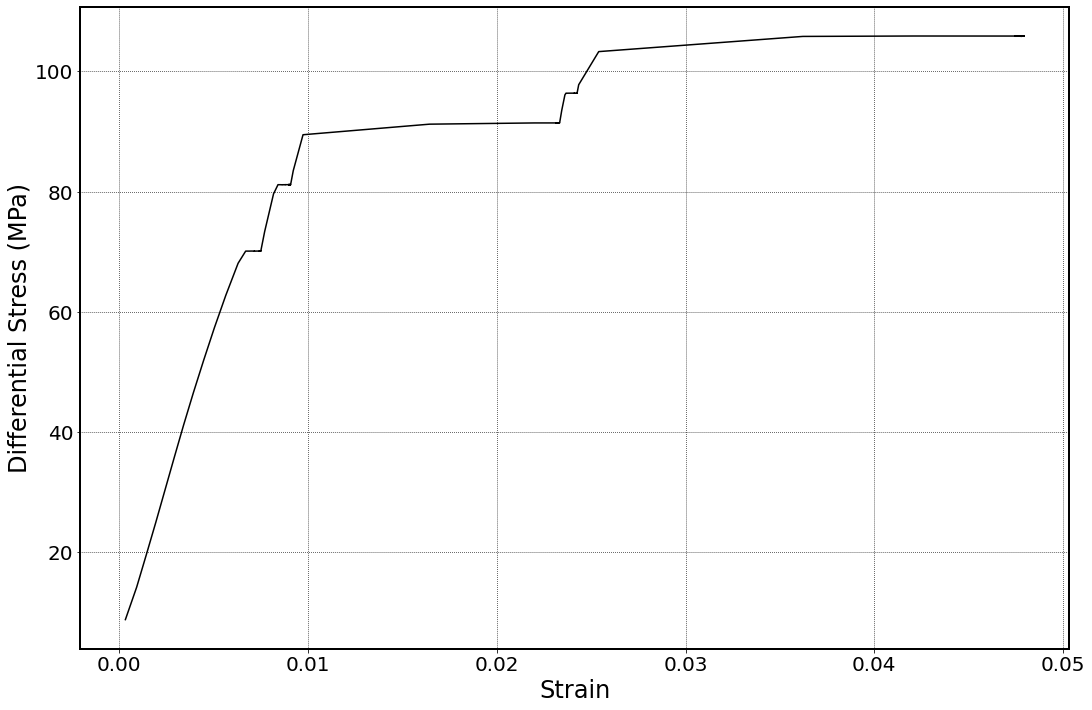

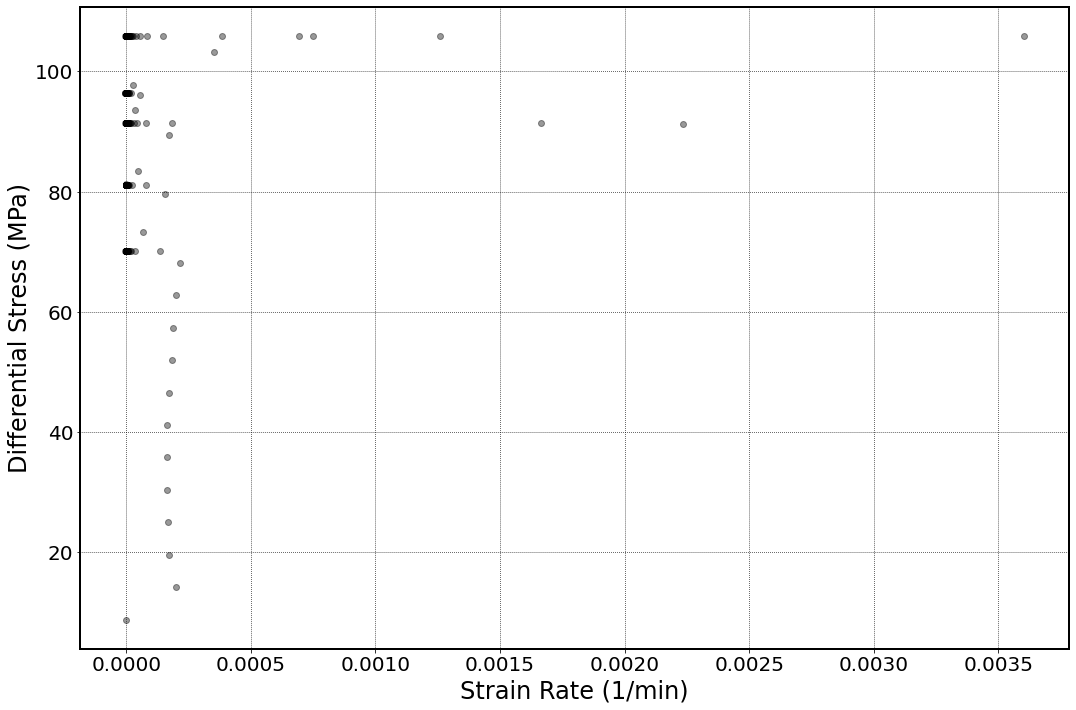

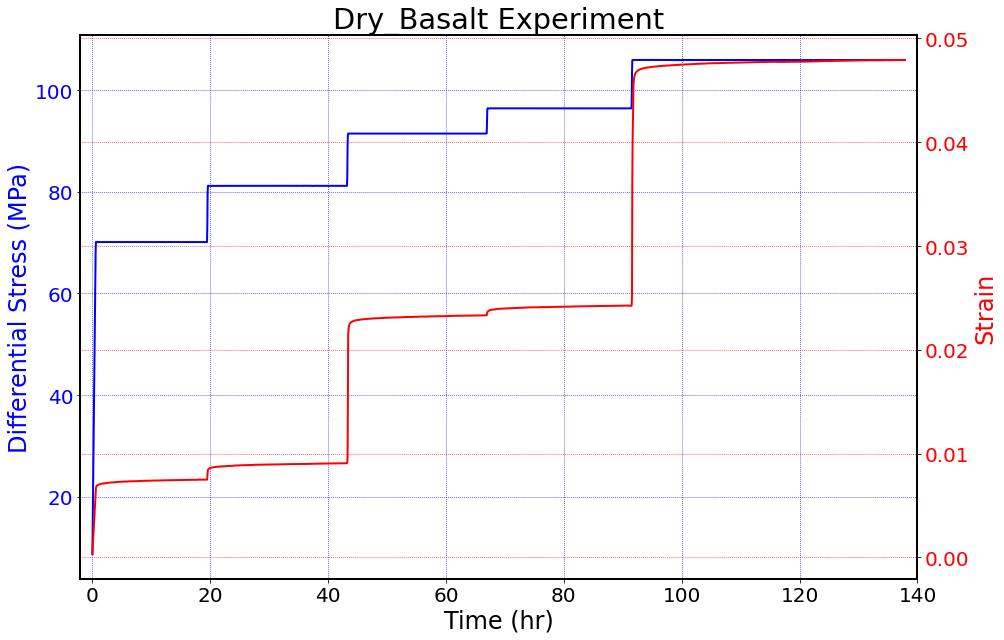

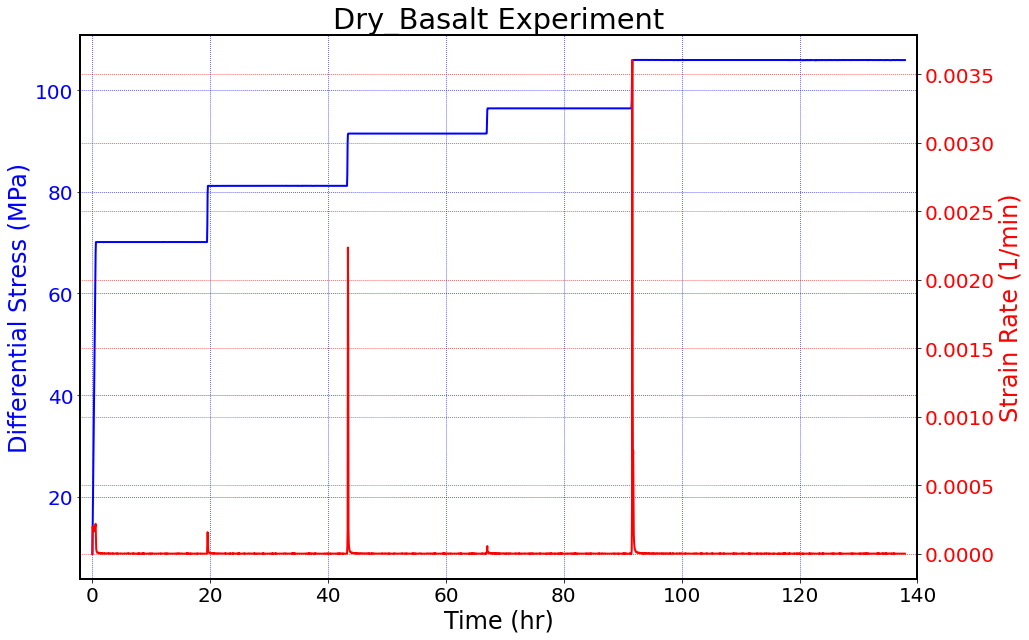

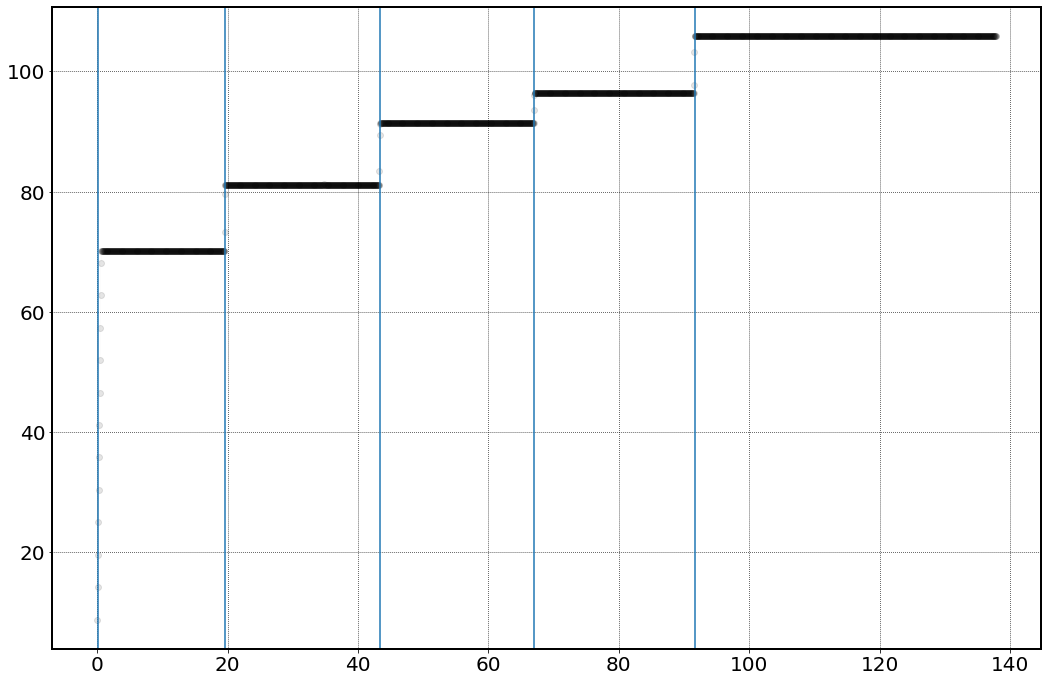

In [57]:
time_window = 180
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1    7  235  520  804 1099]
Time(hr) for the stress steps:  [ 0.12458333 19.62444444 43.37458333 67.04125    91.62458333]


53906

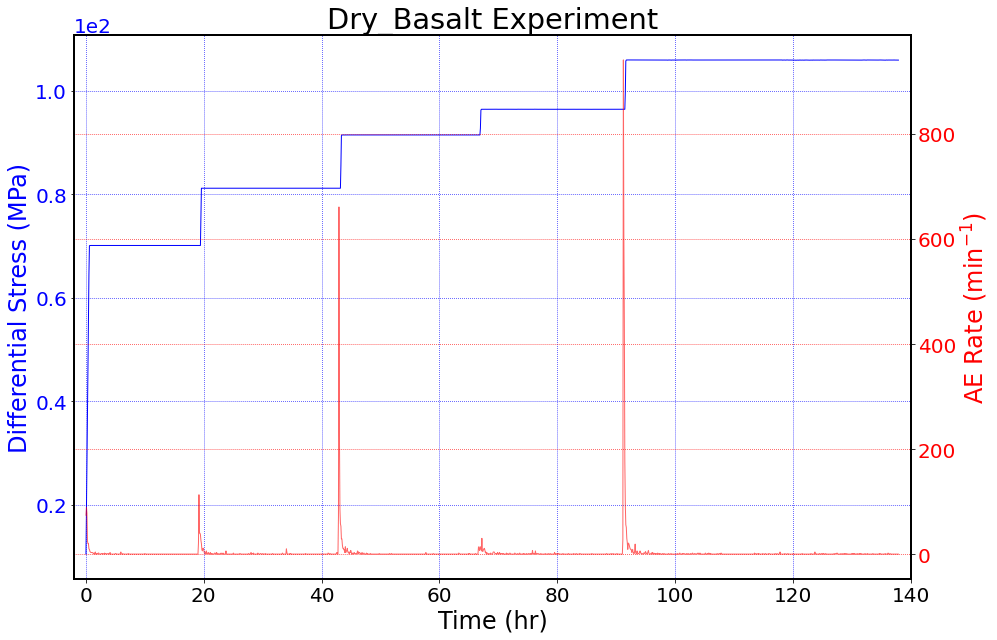

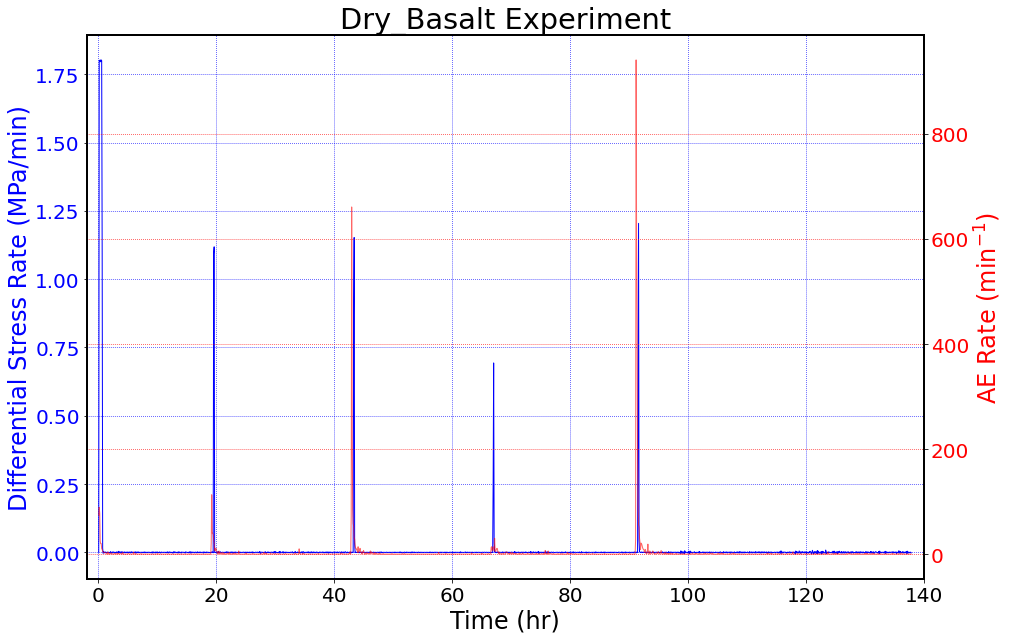

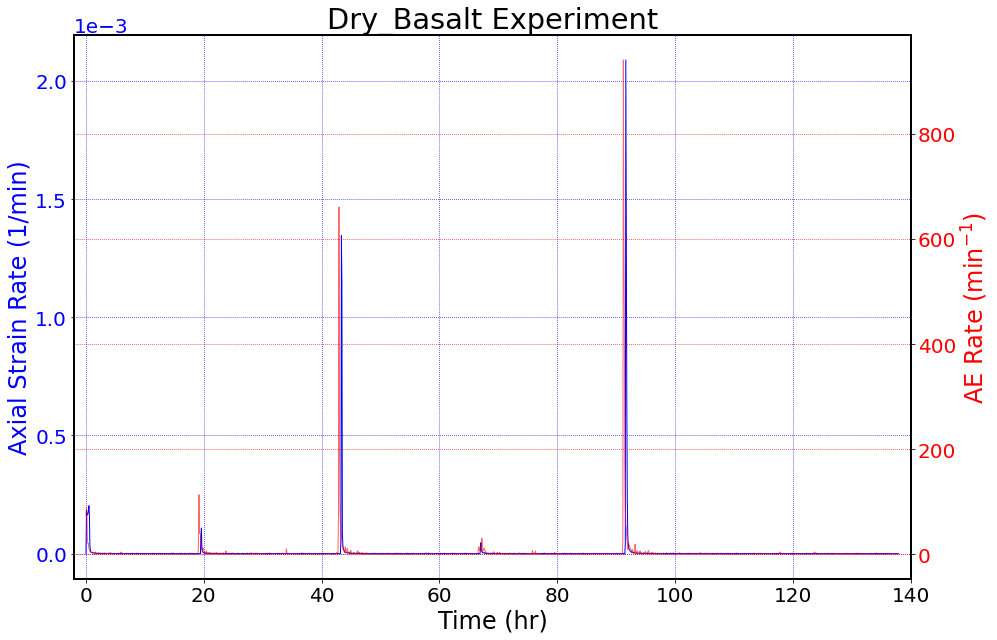

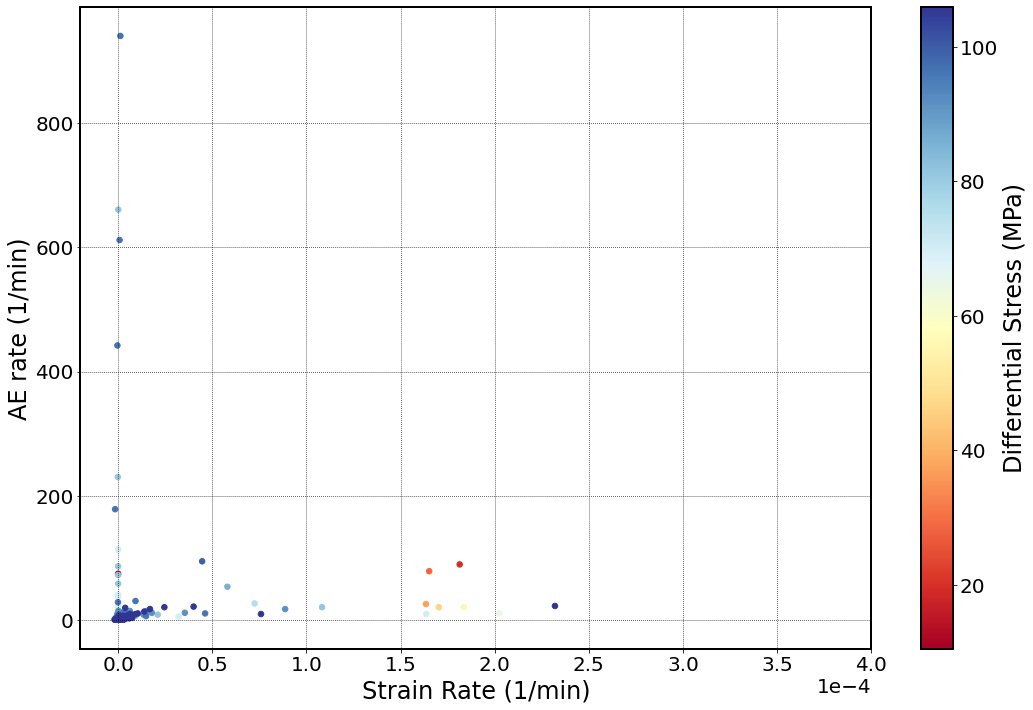

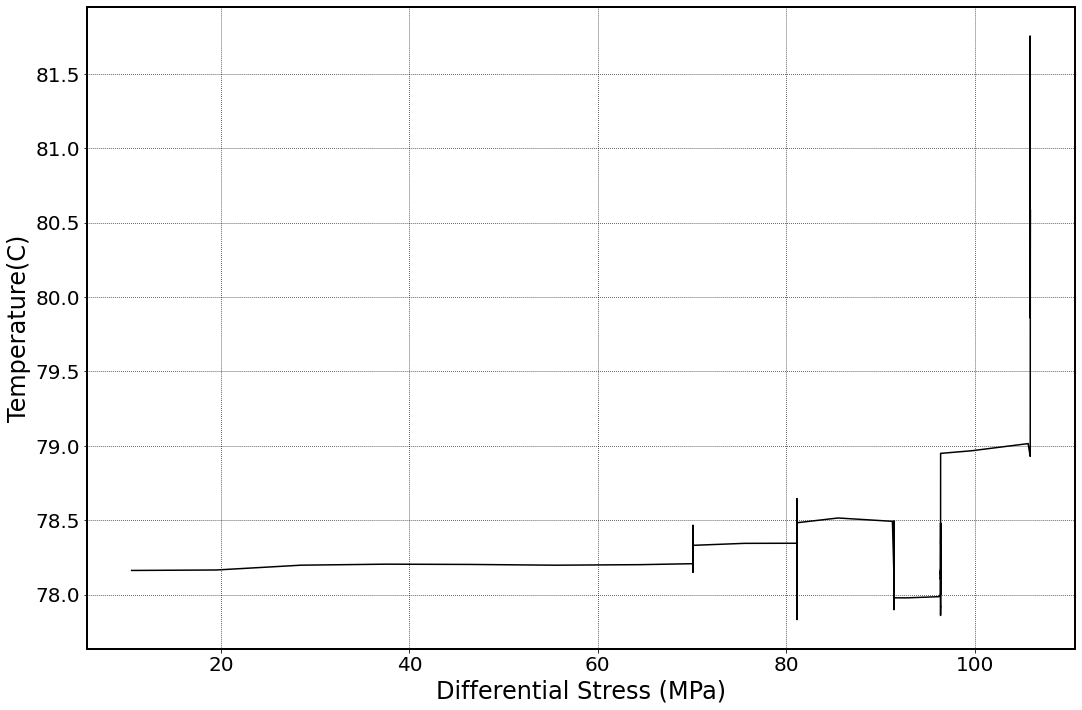

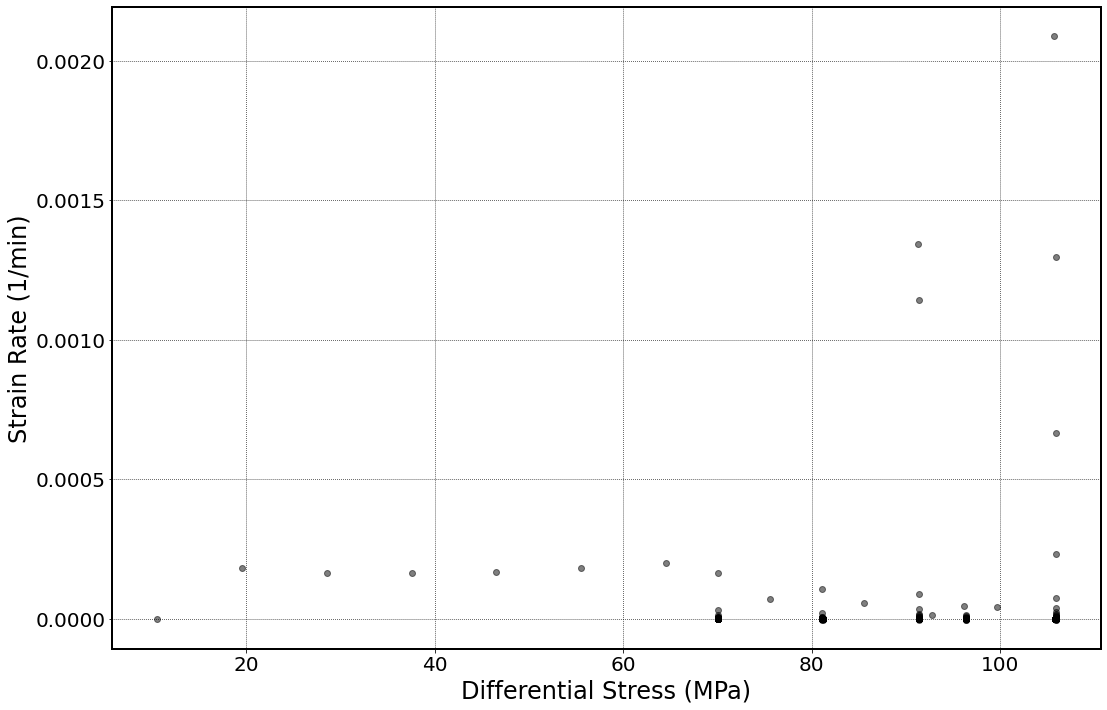

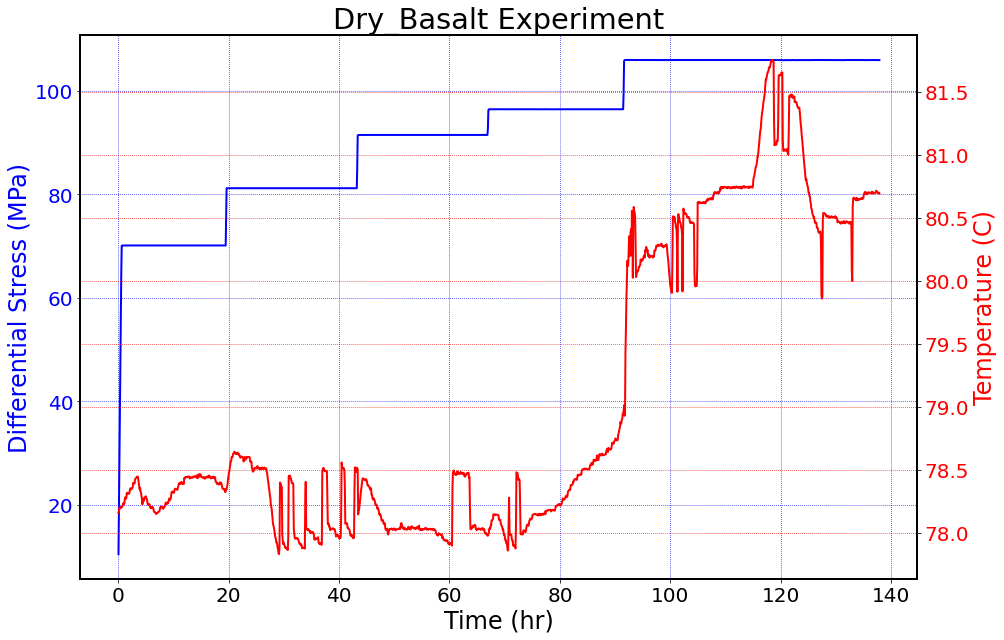

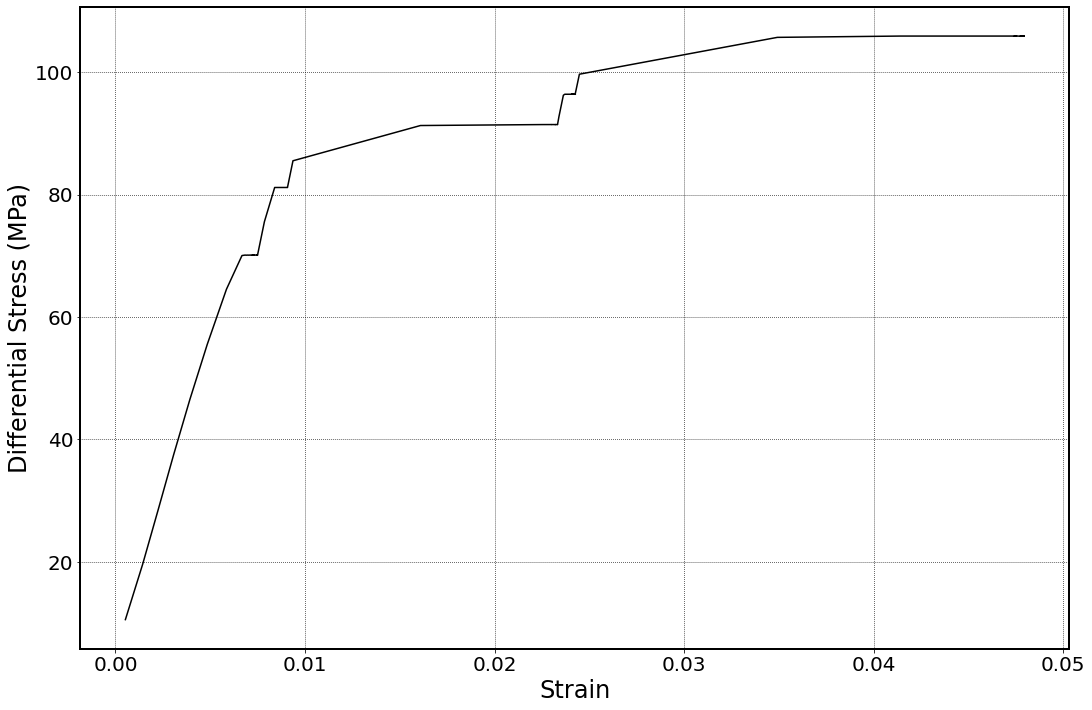

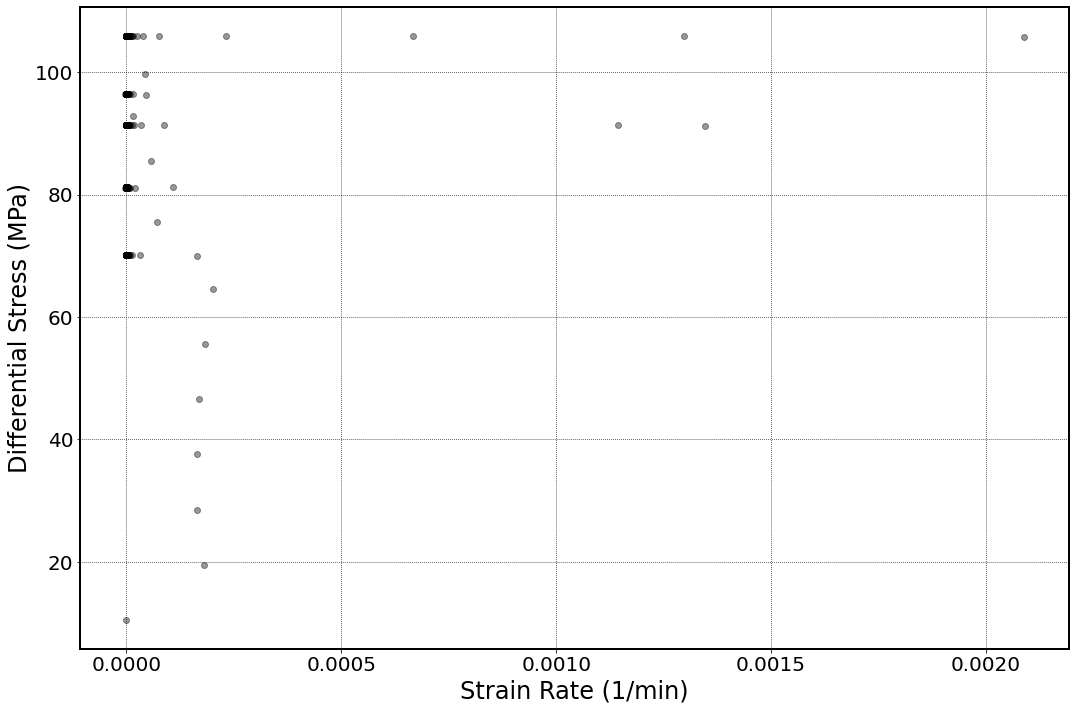

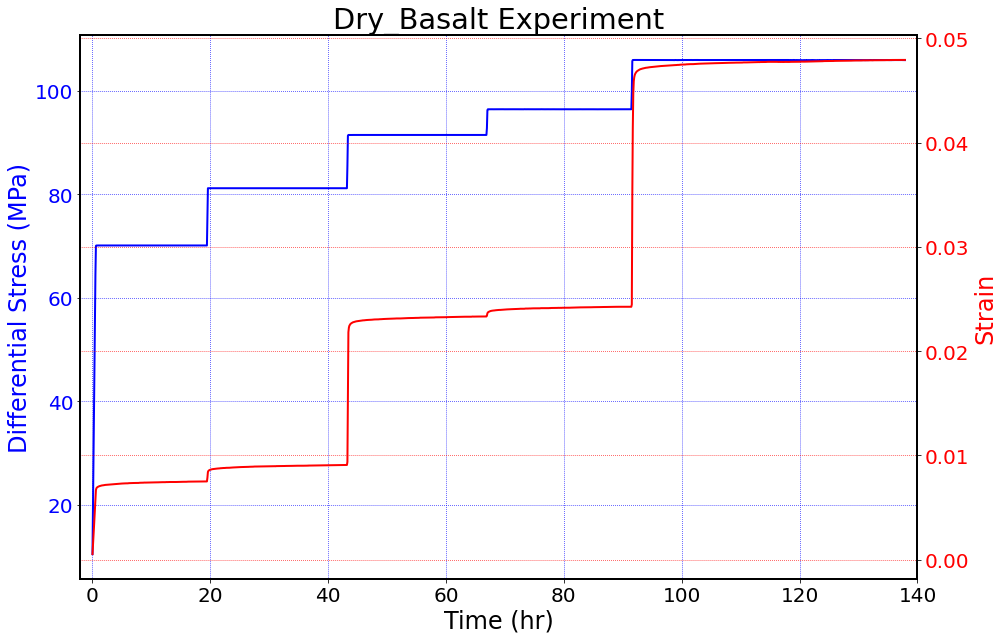

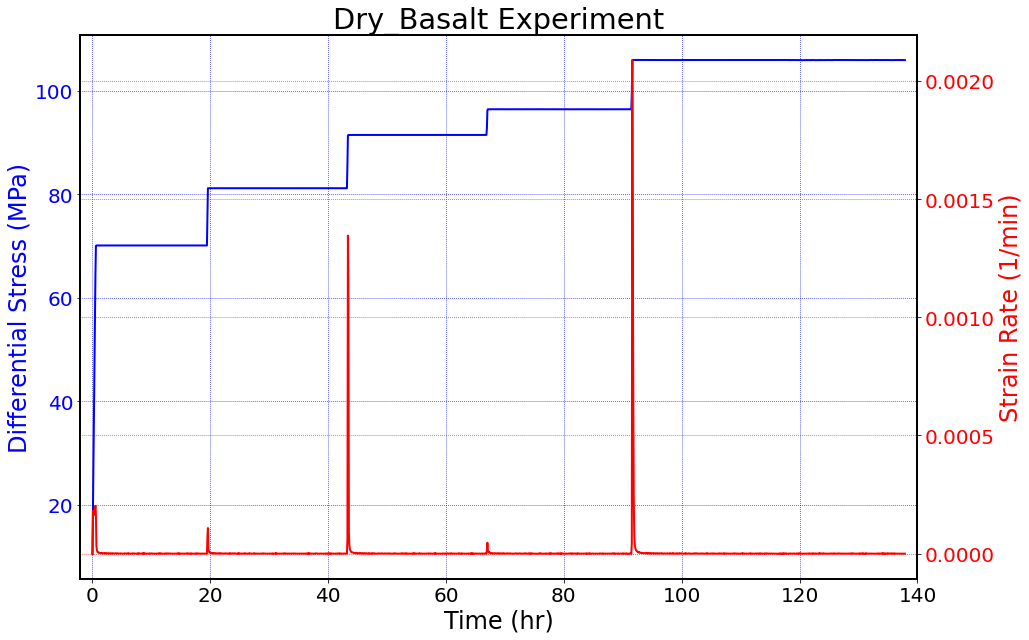

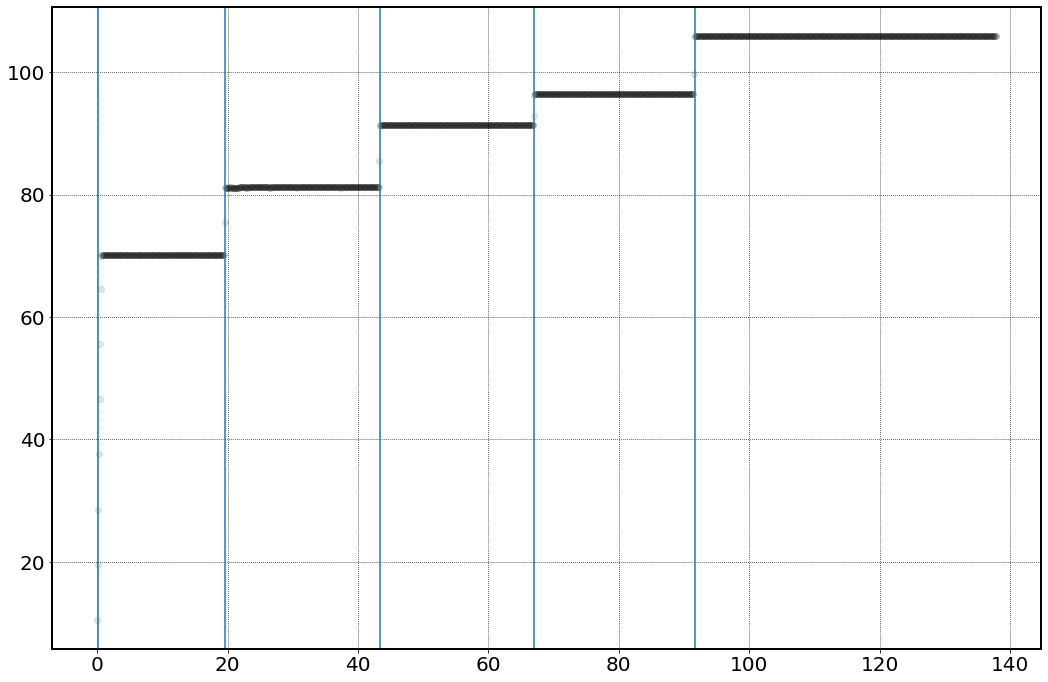

In [58]:
time_window = 300
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [  1   4 118 260 402 550]
Time(hr) for the stress steps:  [ 0.24958333 19.74944444 43.41625    67.08291667 91.74958333]


52610

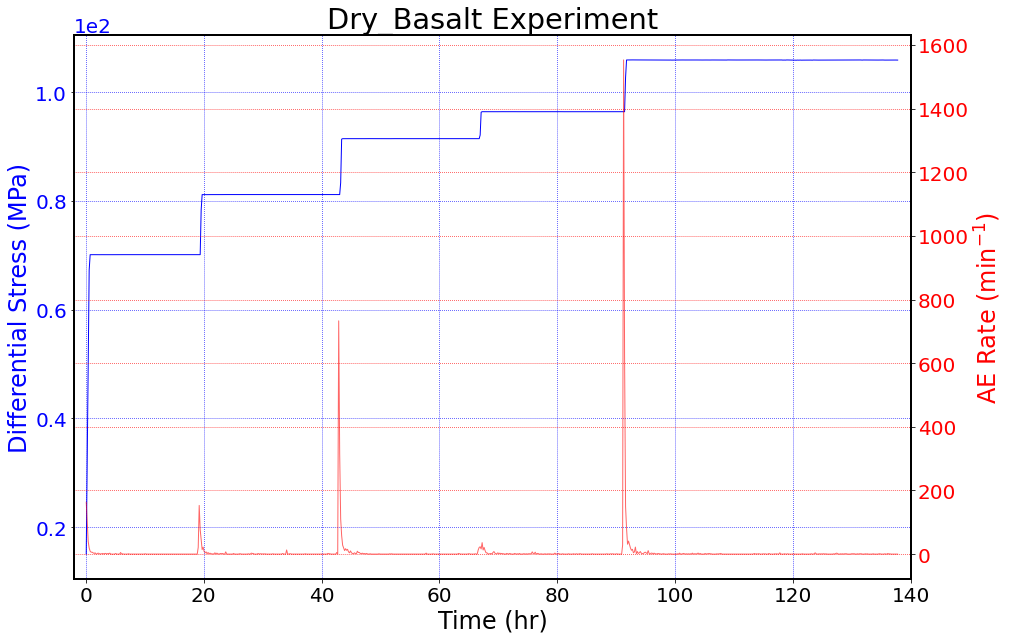

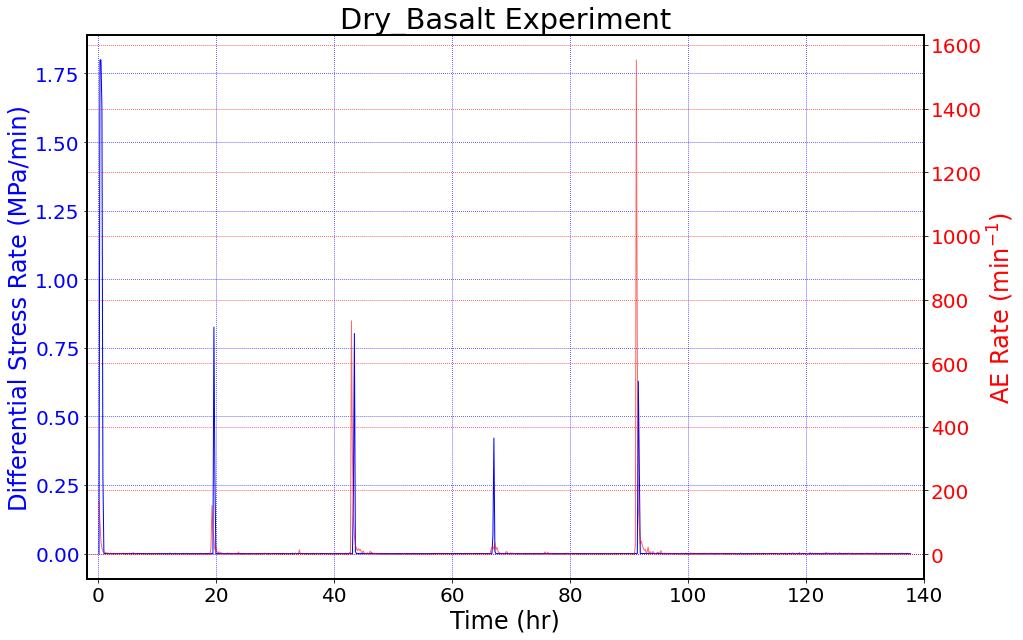

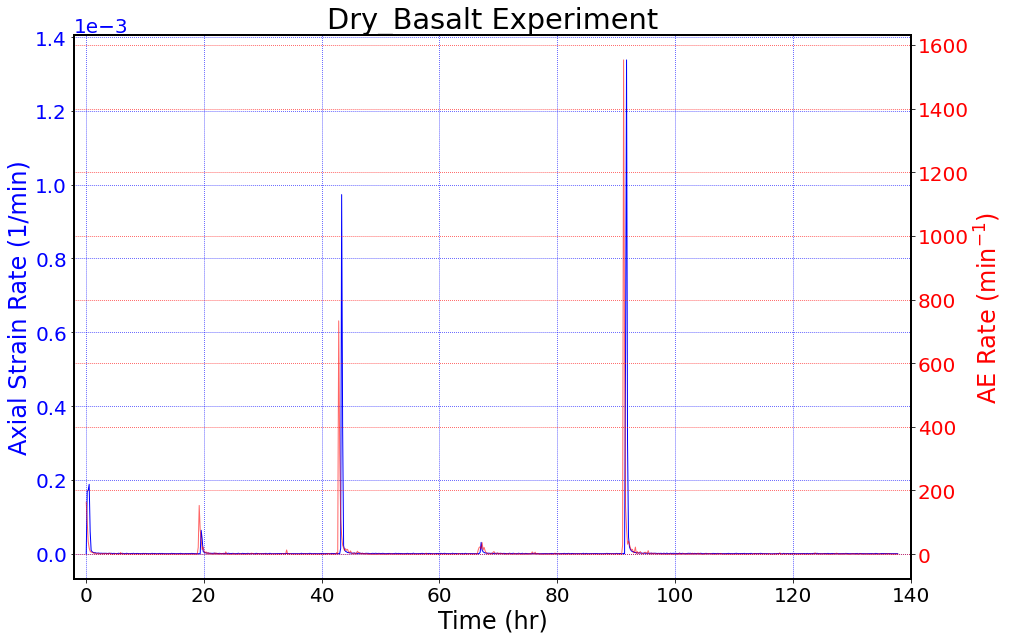

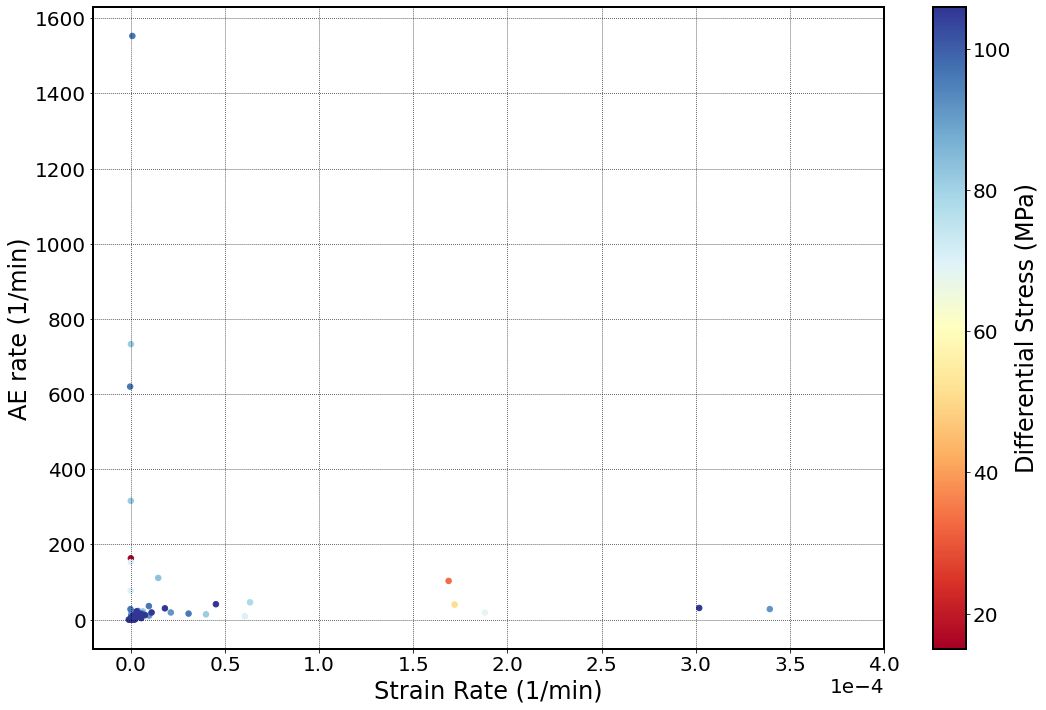

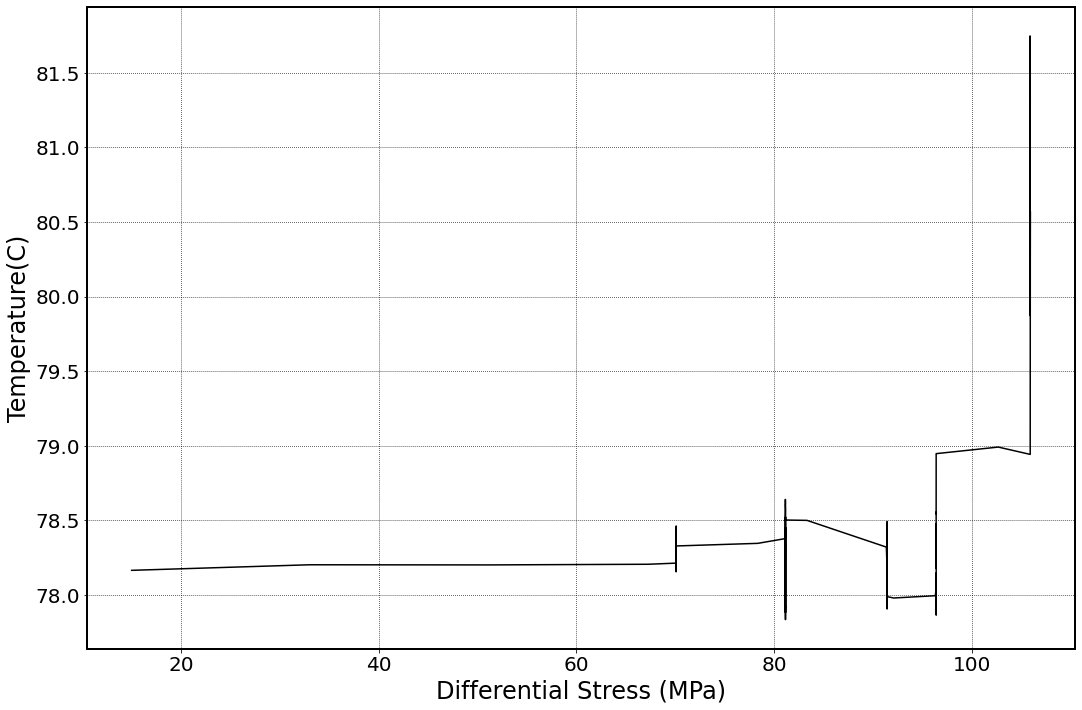

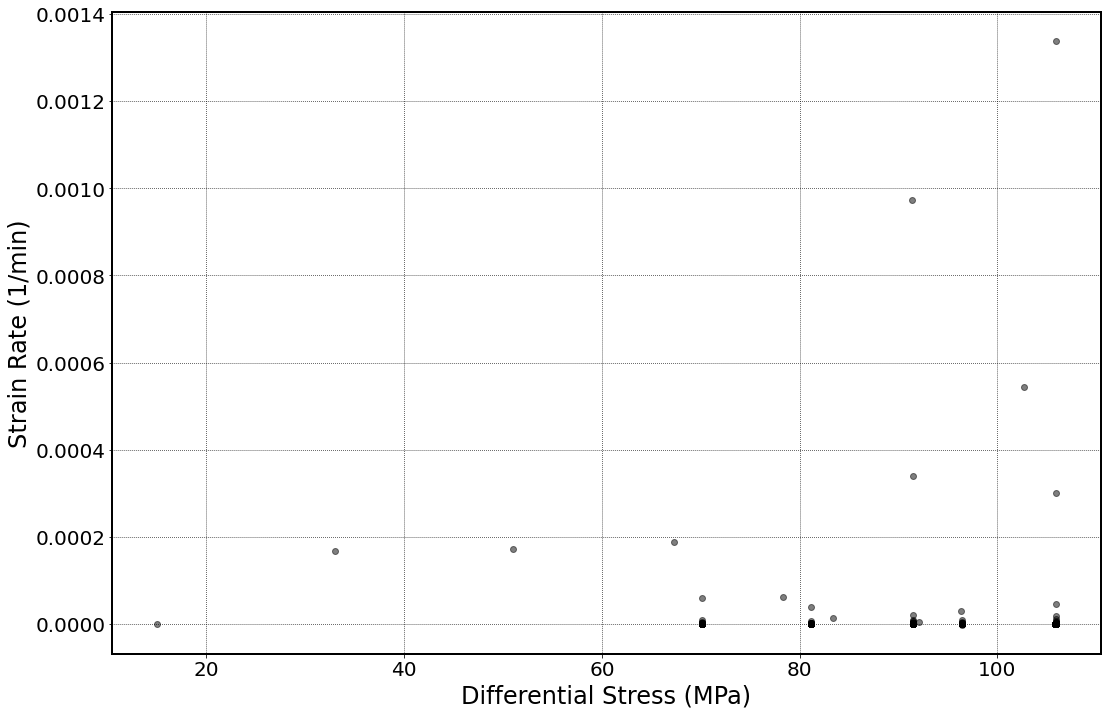

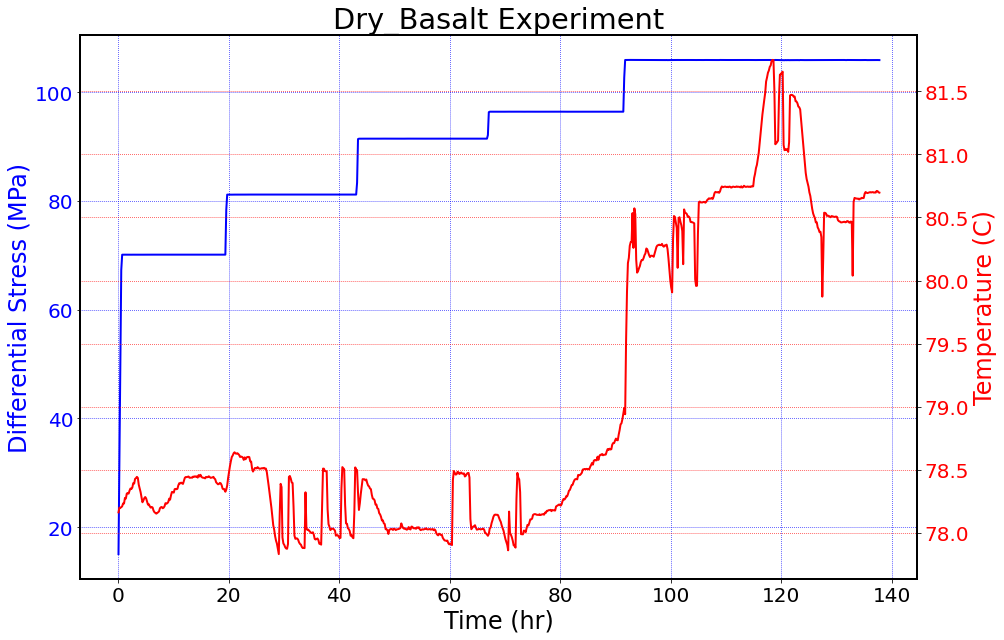

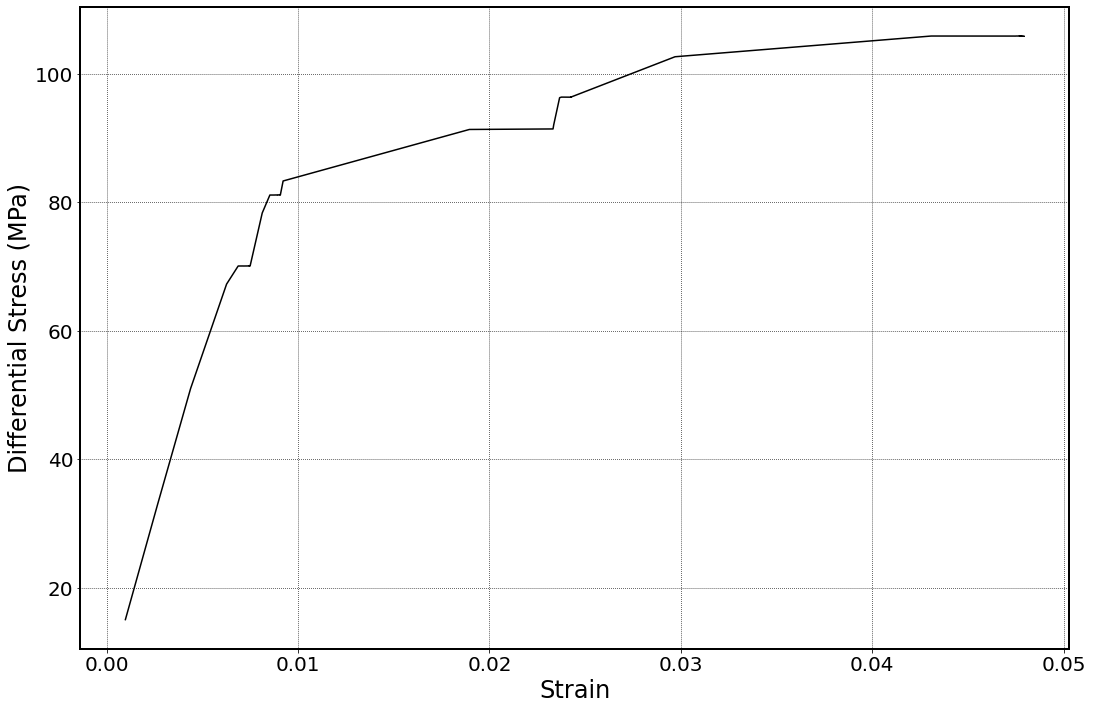

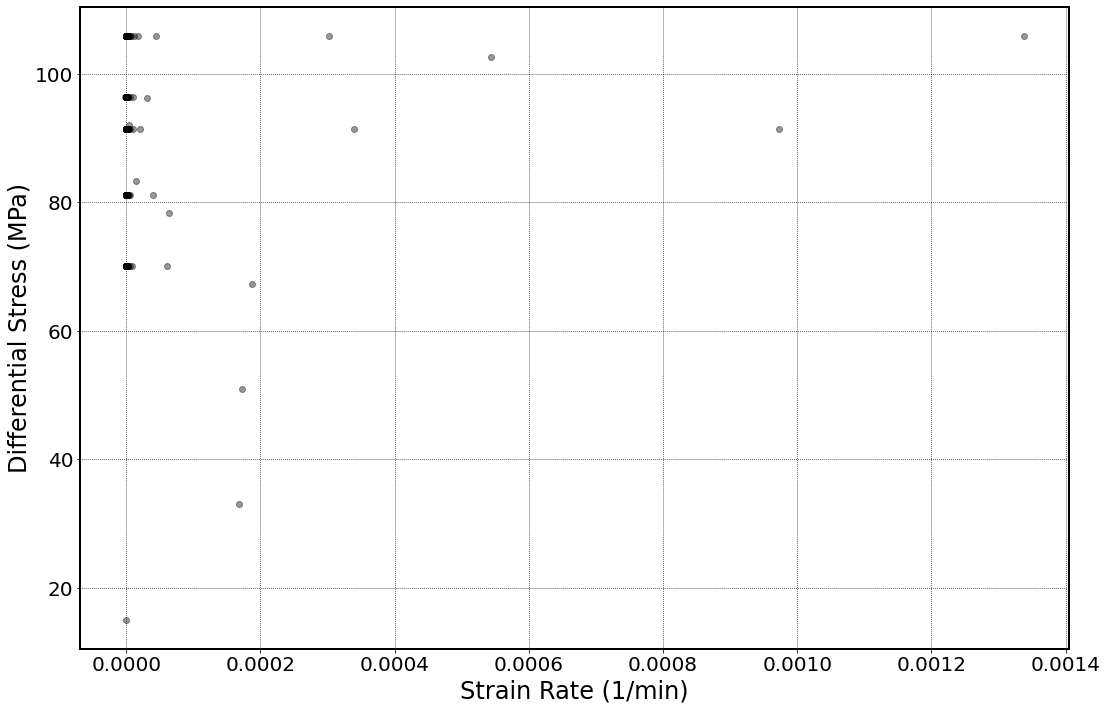

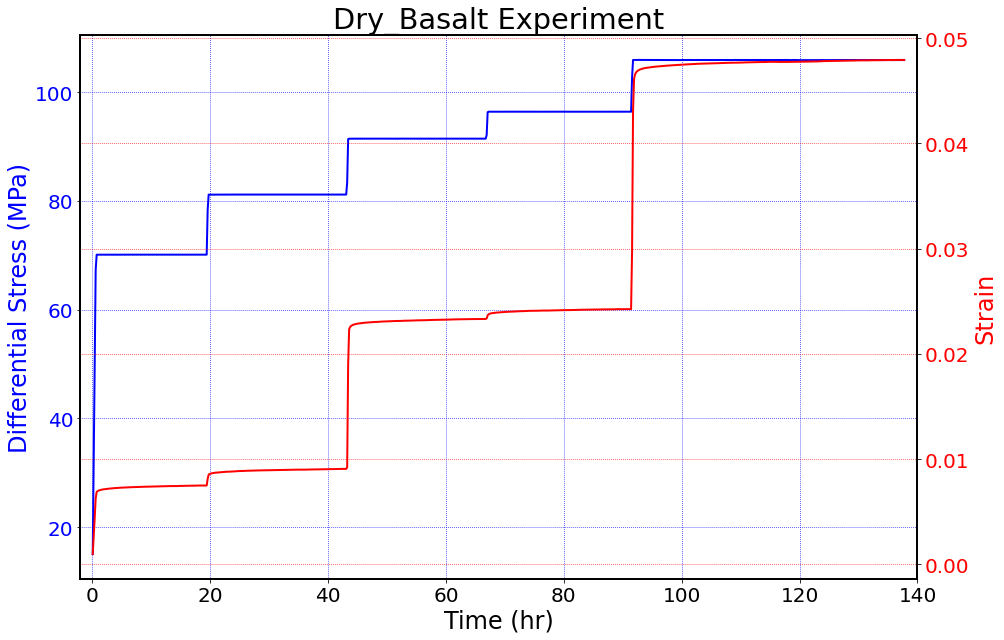

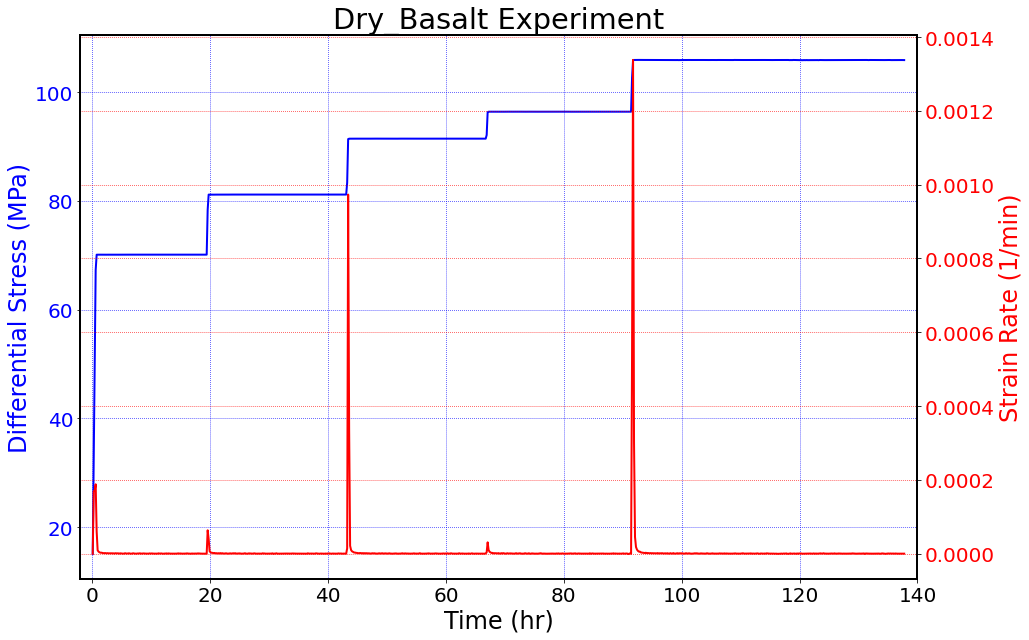

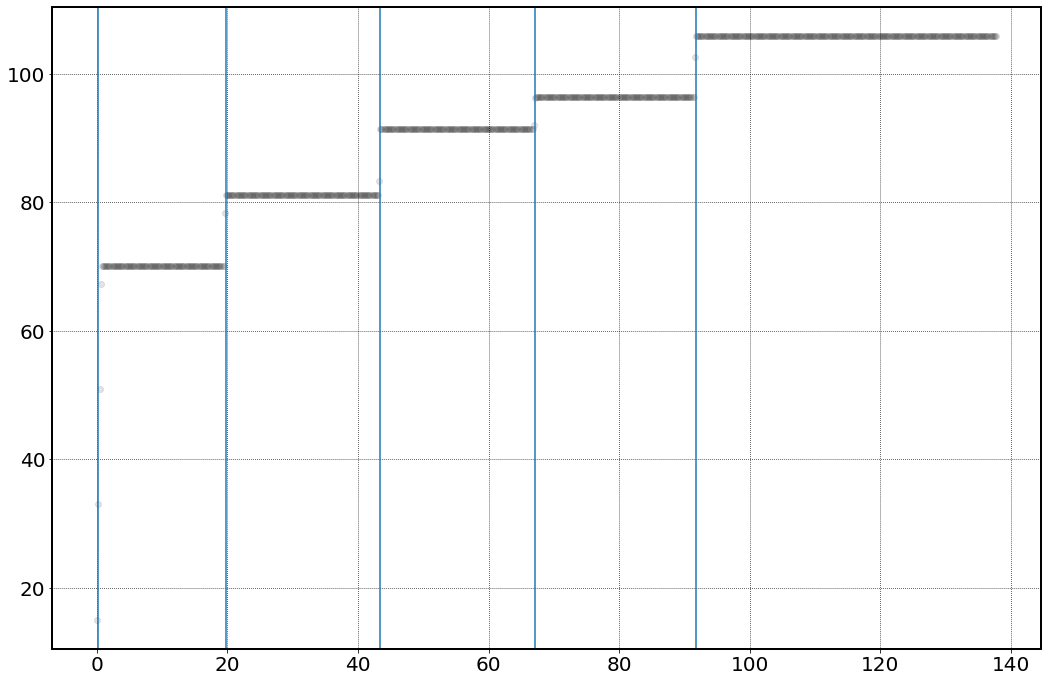

In [59]:
time_window = 600
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()
